<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/GCW_playcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
# Comment after installation so that the whole notebook can be run in one go
install.packages('gbm')
install.packages('xgboost')
install.packages('pROC')
install.packages('reshape2')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Load Libraries

In [ ]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(gbm)
library(reshape2)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loaded gbm 2.1.8.1


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from 

# Create Functions

**Actual vs Expected Plot**

The A vs E plot function here accepts the dimension variable to review along with the actual and expected response information. The graph will show the ratio of these results to weight. Input actual, expected and weight accordingly. Also, no binning takes place within the code. Please create a binned version for review before passing the information into the function where desired.

In [ ]:
## avse.plot.classification includes an off balance for when the model overall predicts low or high
## this is essentially the resid.plot function used later in the regression case study
## here, actual and pred align and both are "numerators"
## in resid.plot, we pass actual loss and pred pure prem, so converting pred pure prem
## is necessary. But, I digress.
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}


# Build Our First GBM (today)

**Simulate Some Data**

First, we will create a dataset to model on. For our purposes, we'll borrow qualitatively our belief about risk differences by age.


*   Set x.Age to be between 16 and 90
*   Set probability of event to be some form of cosine function
*   Use the probabilities to generate binary outcomes



In [ ]:
set.seed(31301)
N <- 200000
x.Age <- sample(16:90, N, replace = TRUE)
exposures <- rep(1, N)
y.truth <- (1+0.25*cos((x.Age-15)*pi/45))*.2
y.out <- rbinom(N, 1, prob=y.truth)

In [ ]:
df <- data.frame(x.Age, exposures, y.truth, y.out)

In [ ]:
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.5,0.5))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [ ]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]


With the data in place, let's take just a little time to visualize our data.

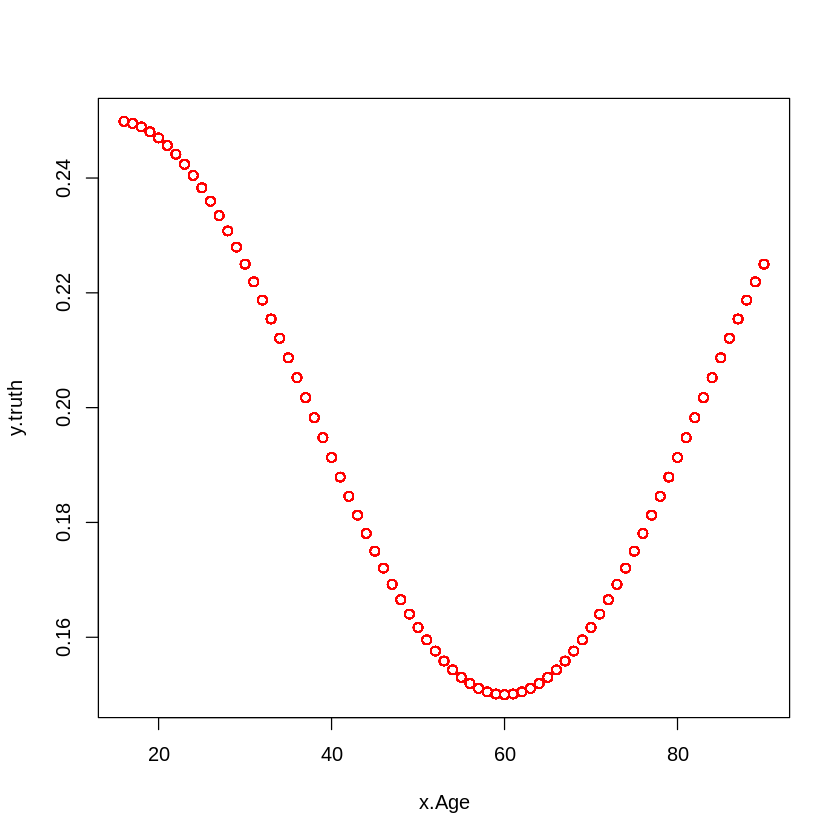

In [ ]:
with(df.train, plot(x.Age, y.truth, col="red"))

In [ ]:
df2 <- df.train %>% 
  group_by(x.Age) %>% 
  summarise(reccnt = n(), 
            sum.true = sum(y.truth),
            sum.actual = sum(y.out)) %>%
  mutate(f.true = sum.true / reccnt,
         f.actual = sum.actual / reccnt)
df2                
              

x.Age,reccnt,sum.true,sum.actual,f.true,f.actual
<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
16,1346,336.3361,329,0.2498782,0.2444279
17,1239,309.1471,303,0.2495134,0.2445521
18,1314,327.0643,317,0.2489074,0.2412481
19,1273,315.7843,320,0.2480631,0.2513747
20,1286,317.6222,350,0.2469846,0.2721617
21,1326,325.7681,335,0.2456773,0.2526395
22,1327,323.9836,320,0.2441474,0.2411454
23,1320,319.9712,314,0.2424024,0.2378788
24,1345,323.4064,345,0.2404508,0.2565056


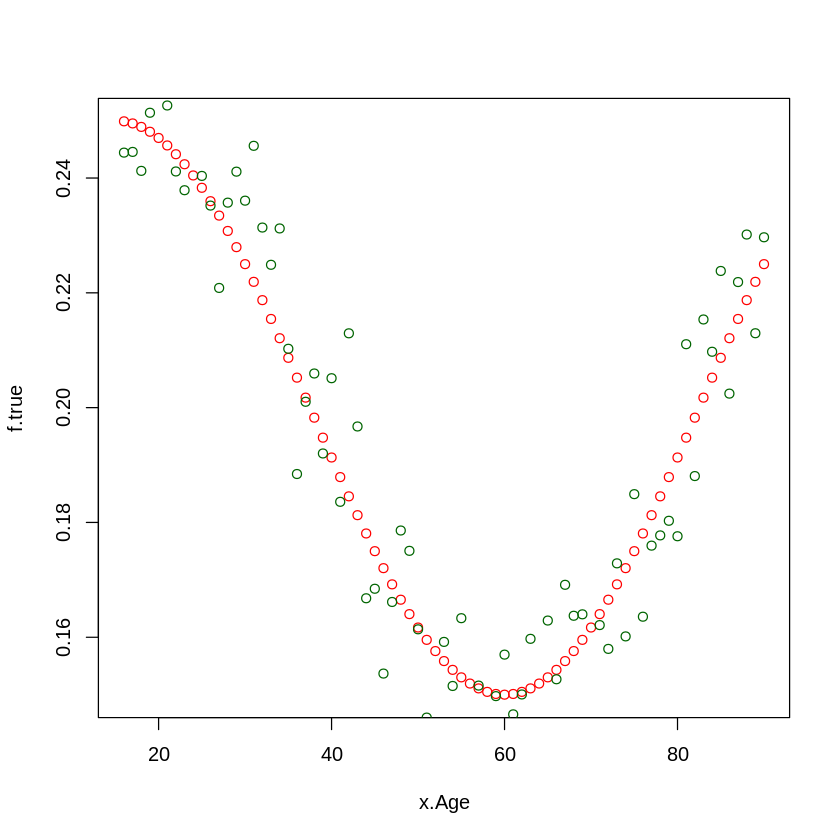

In [ ]:
with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))

Let's take a moment and get familiar with the actual versus expected plotting function.

In the function below, by setting actual and predicted both to y.out, you get the univariate review of the actual results. Here, because we have the original probabilities, we can further set actual to y.truth and predicted to y.out, and get a visual comparison of the simulated results against the underlying truth.

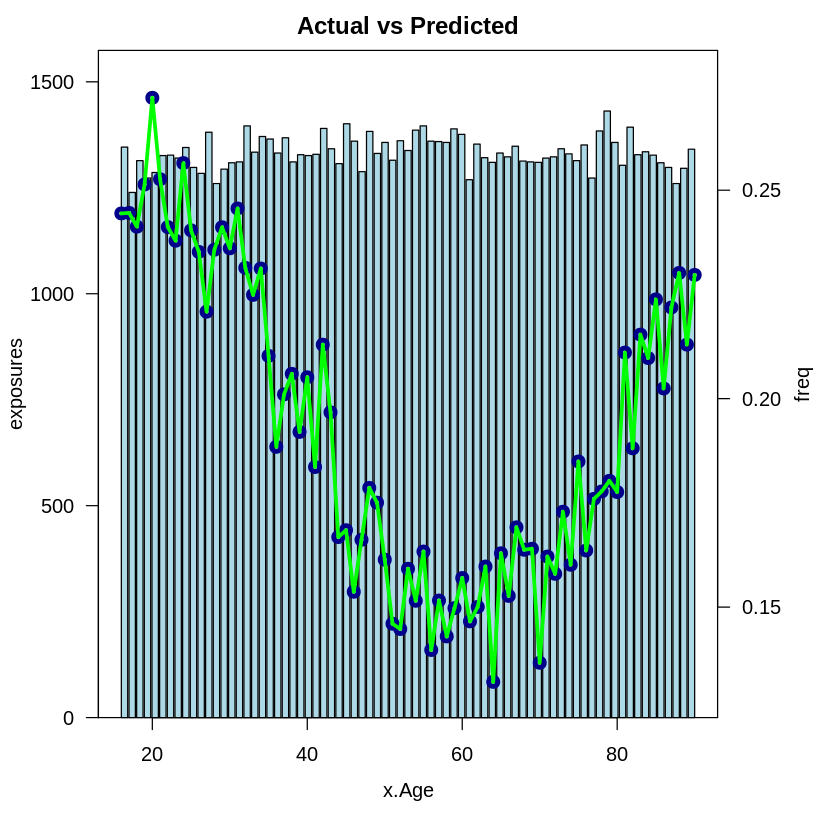

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.out",weight="exposures",lt_text="exposures",rt_text="freq")

Now, we're ready to start modeling. First, we'll work through some logistic regressions, along with polynomic forms.

In [ ]:
m.glm <- glm(y.train ~ x.Age, data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm <- predict(m.glm, newdata=x.train, type="response")
df.test$y.pred.glm <- predict(m.glm, newdata=x.test, type="response")
summary(m.glm)


Call:
glm(formula = y.train ~ x.Age, family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7134  -0.6735  -0.6384  -0.6033   1.9058  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.1520303  0.0208566  -55.24   <2e-16 ***
x.Age       -0.0054046  0.0003736  -14.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97696  on 99972  degrees of freedom
AIC: 97700

Number of Fisher Scoring iterations: 4


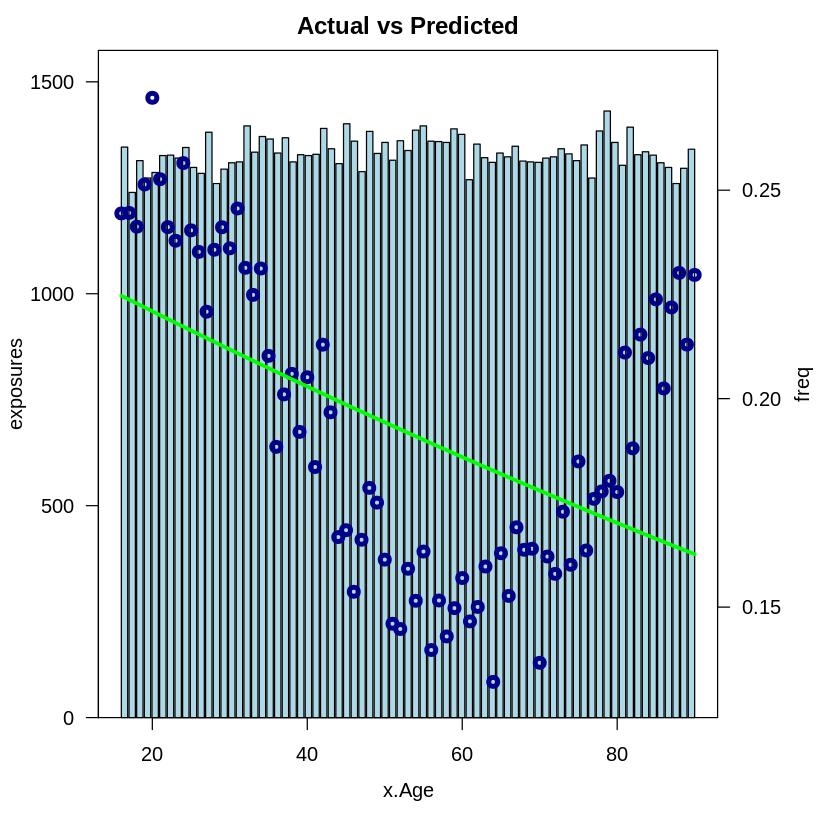

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

In [ ]:
m.glm2 <- glm(y.train ~ poly(x.Age,2), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm2 <- predict(m.glm2, newdata=x.train, type="response")
df.test$y.pred.glm2 <- predict(m.glm2, newdata=x.test, type="response")
summary(m.glm2)

m.glm3 <- glm(y.train ~ poly(x.Age,3), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm3 <- predict(m.glm3, newdata=x.train, type="response")
df.test$y.pred.glm3 <- predict(m.glm3, newdata=x.test, type="response")
summary(m.glm3)


Call:
glm(formula = y.train ~ poly(x.Age, 2), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8281  -0.6658  -0.6140  -0.5934   1.9112  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.447005   0.008107 -178.50   <2e-16 ***
poly(x.Age, 2)1 -33.798828   2.442156  -13.84   <2e-16 ***
poly(x.Age, 2)2  53.669550   2.479010   21.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97234  on 99971  degrees of freedom
AIC: 97240

Number of Fisher Scoring iterations: 4



Call:
glm(formula = y.train ~ poly(x.Age, 3), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7752  -0.6843  -0.6106  -0.5763   1.9402  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.449131   0.008124 -178.381   <2e-16 ***
poly(x.Age, 3)1 -35.630016   2.448474  -14.552   <2e-16 ***
poly(x.Age, 3)2  54.607142   2.477759   22.039   <2e-16 ***
poly(x.Age, 3)3  21.566963   2.481274    8.692   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97158  on 99970  degrees of freedom
AIC: 97166

Number of Fisher Scoring iterations: 4


In [ ]:
m.glm9 <- glm(y.train ~ poly(x.Age,9), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm9 <- predict(m.glm9, newdata=x.train, type="response")
df.test$y.pred.glm9 <- predict(m.glm9, newdata=x.test, type="response")
summary(m.glm9)


Call:
glm(formula = y.train ~ poly(x.Age, 9), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7630  -0.6994  -0.6053  -0.5718   1.9471  

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.44993    0.00813 -178.333  < 2e-16 ***
poly(x.Age, 9)1 -35.19172    2.44530  -14.392  < 2e-16 ***
poly(x.Age, 9)2  55.73235    2.51290   22.178  < 2e-16 ***
poly(x.Age, 9)3  21.18474    2.50257    8.465  < 2e-16 ***
poly(x.Age, 9)4 -12.84941    2.51180   -5.116 3.13e-07 ***
poly(x.Age, 9)5  -1.80144    2.50773   -0.718    0.473    
poly(x.Age, 9)6   0.84000    2.50835    0.335    0.738    
poly(x.Age, 9)7  -2.03703    2.50660   -0.813    0.416    
poly(x.Age, 9)8  -3.56014    2.49934   -1.424    0.154    
poly(x.Age, 9)9   1.60669    2.49710    0.643    0.520    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to 

In [ ]:
m.glm4 <- glm(y.train ~ poly(x.Age,4), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm4 <- predict(m.glm4, newdata=x.train, type="response")
df.test$y.pred.glm4 <- predict(m.glm4, newdata=x.test, type="response")
summary(m.glm4)


Call:
glm(formula = y.train ~ poly(x.Age, 4), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7602  -0.6925  -0.6087  -0.5708   1.9492  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.449808   0.008129 -178.348  < 2e-16 ***
poly(x.Age, 4)1 -35.157658   2.444799  -14.381  < 2e-16 ***
poly(x.Age, 4)2  55.647256   2.509606   22.174  < 2e-16 ***
poly(x.Age, 4)3  21.123439   2.494221    8.469  < 2e-16 ***
poly(x.Age, 4)4 -12.711745   2.494108   -5.097 3.46e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97132  on 99969  degrees of freedom
AIC: 97142

Number of Fisher Scoring iterations: 4


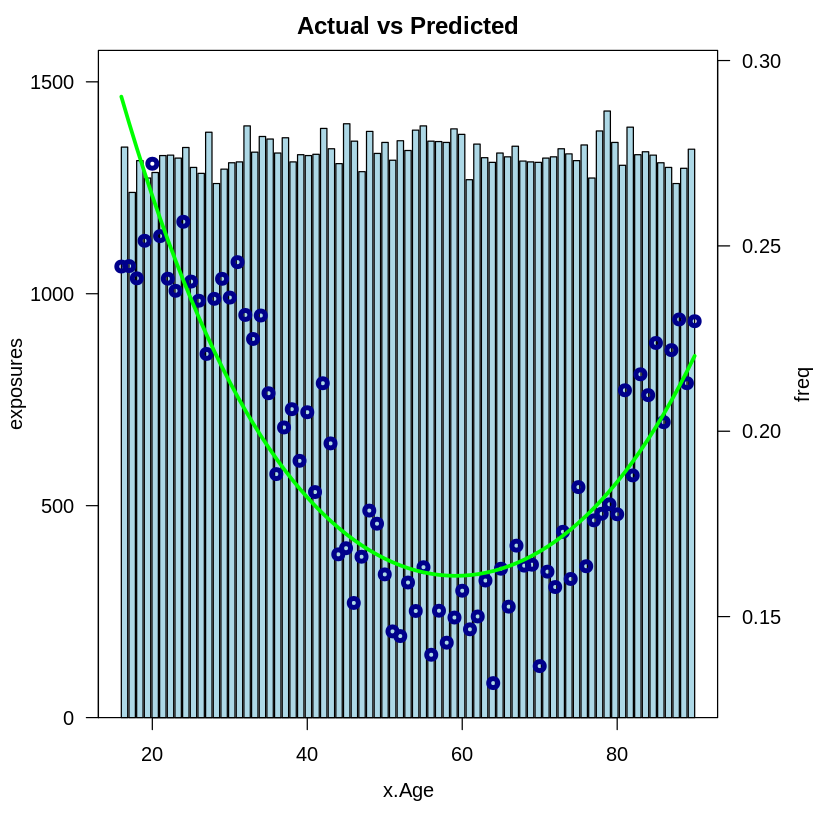

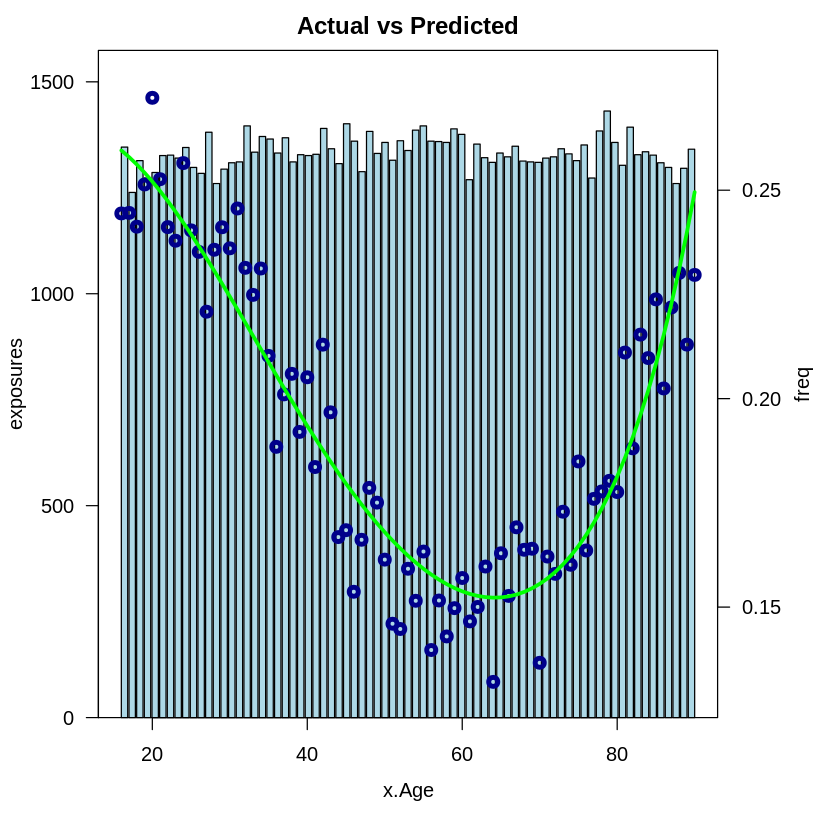

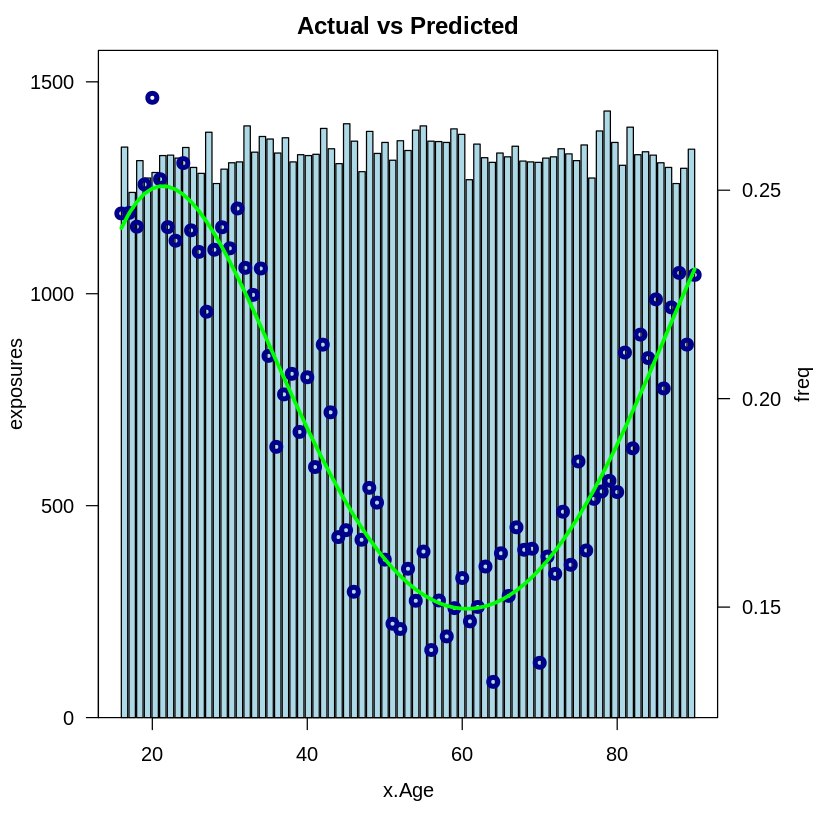

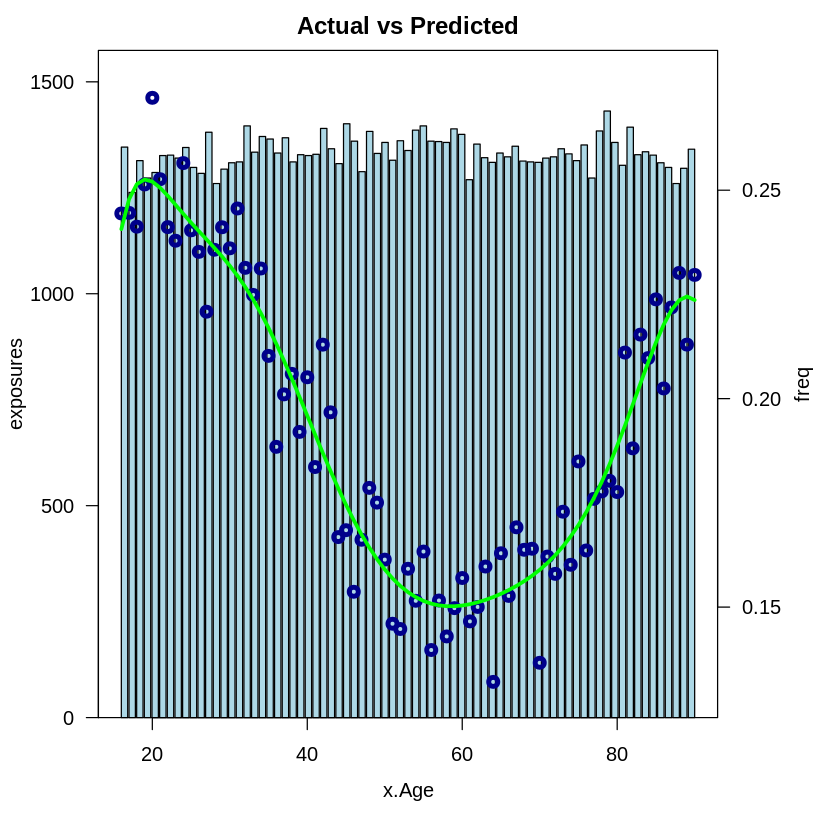

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm2",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm3",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm4",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm9",weight="exposures",lt_text="exposures",rt_text="freq")

With only one dimension for the model, it's easy to predict to each level directly. We already have a summarized file in df2. We'll use that to gather the GLM predictions and display them cleanly.

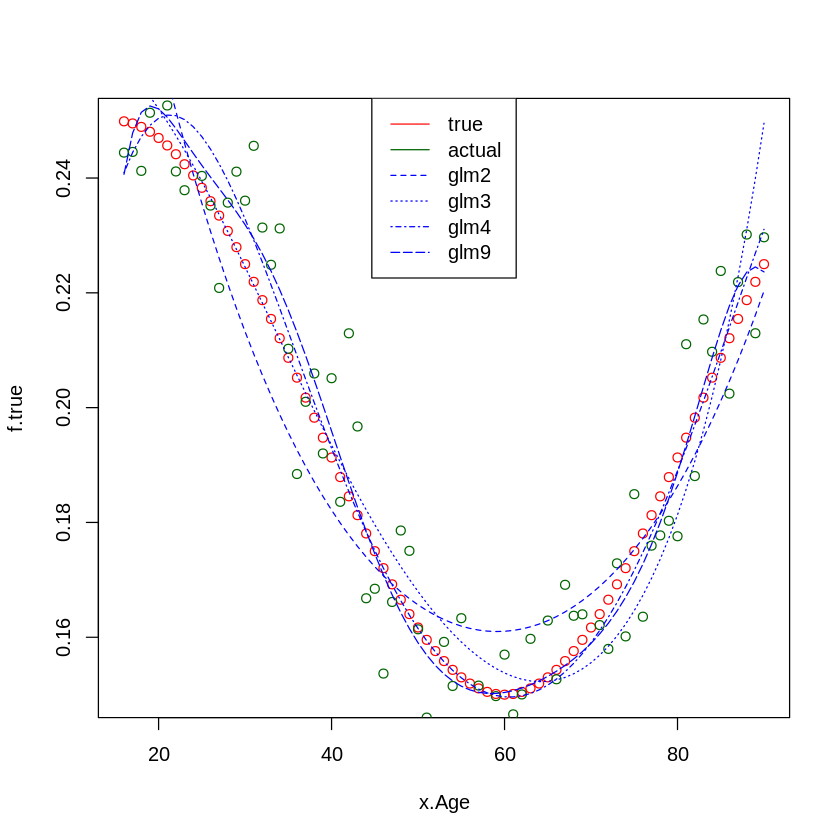

In [ ]:
df2$f.pred.glm <- predict(m.glm, newdata=df2, type="response")
df2$f.pred.glm2 <- predict(m.glm2, newdata=df2, type="response")
df2$f.pred.glm3 <- predict(m.glm3, newdata=df2, type="response")
df2$f.pred.glm4 <- predict(m.glm4, newdata=df2, type="response")
df2$f.pred.glm9 <- predict(m.glm9, newdata=df2, type="response")

with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))
with(df2, lines(x.Age, f.pred.glm2, lty = 2, col="blue"))
with(df2, lines(x.Age, f.pred.glm3, lty = 3, col="blue"))
with(df2, lines(x.Age, f.pred.glm4, lty = 4, col="blue"))
with(df2, lines(x.Age, f.pred.glm9, lty = 5, col="blue"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm4", "glm9"),
       lty=c(1,1,2:5),
       col=c("red", "darkgreen", "blue", "blue", "blue", "blue"))

**GBM TIME**

Now, let's turn our attention to the GBM. Without knowing much else about GBM, let's use as many defaults as we can, and just send the data through the function. Well, except I allowed myself the choice of distribution.

In [ ]:
m.gbm = gbm(y.train ~ x.Age,
            data = x.train,
            distribution = "bernoulli")
df.train$y.pred.gbm <- predict(m.gbm, newdata=df.train, type="response")
df.test$y.pred.gbm <- predict(m.gbm, newdata=df.test, type="response")
df2$f.pred.gbm <- predict(m.gbm, newdata=df2, type="response")

Using 100 trees...


Using 100 trees...


Using 100 trees...




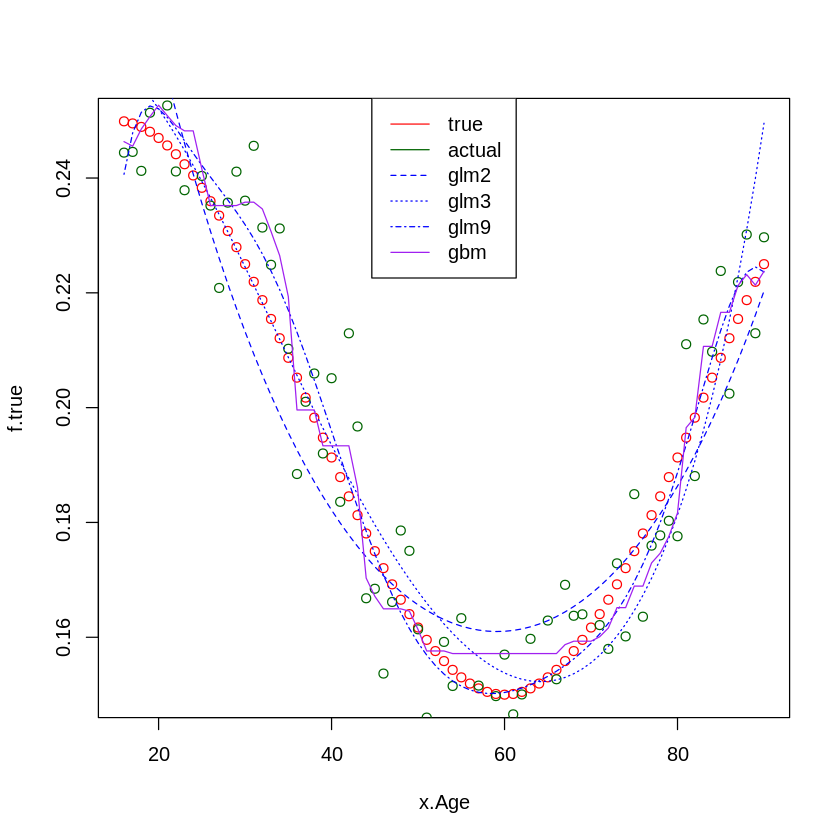

In [ ]:
with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))
with(df2, lines(x.Age, f.pred.glm2, lty = 2, col="blue"))
with(df2, lines(x.Age, f.pred.glm3, lty = 3, col="blue"))
with(df2, lines(x.Age, f.pred.glm9, lty = 4, col="blue"))
with(df2, lines(x.Age, f.pred.gbm, lty = 1, col="purple"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm9", "gbm"),
       lty=c(1,1,2:4,1),
       col=c("red", "darkgreen", "blue", "blue", "blue", "purple"))

***Congrats. There's your first GBM (of today).***

For gbm, the predict function allows you to fit to less trees than the number of round the function actually went through. You can specify in predict with n.trees.

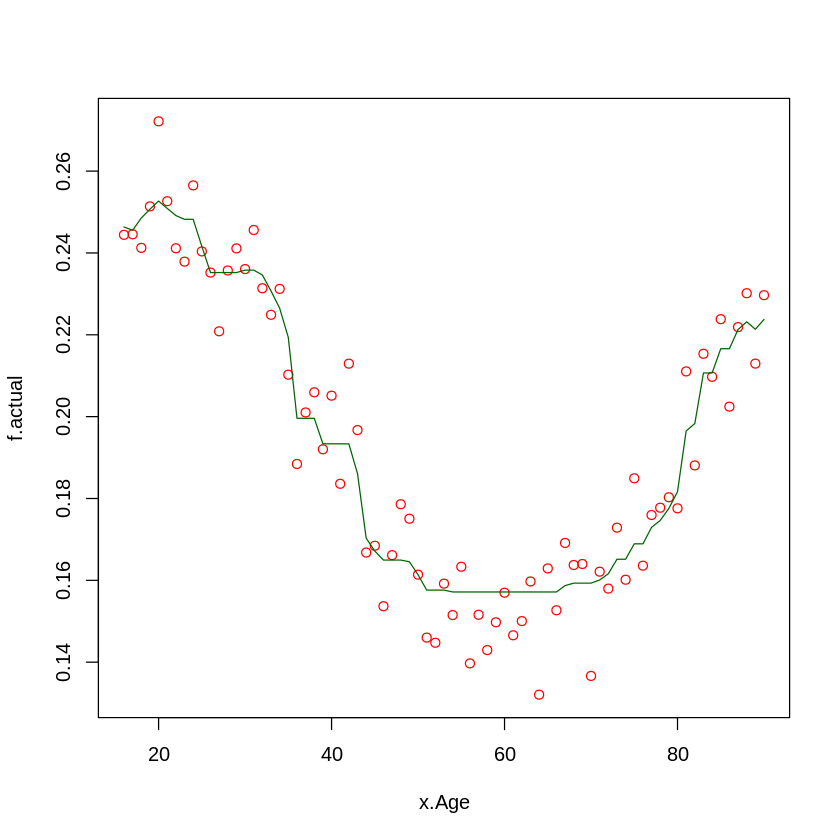

In [ ]:
df2$f.pred.gbm.iter <- predict(m.gbm, newdata=df2, type="response", n.trees=100)
with(df2, plot(x.Age, f.actual, col="red"))
with(df2, lines(x.Age, f.pred.gbm.iter, col="darkgreen"))

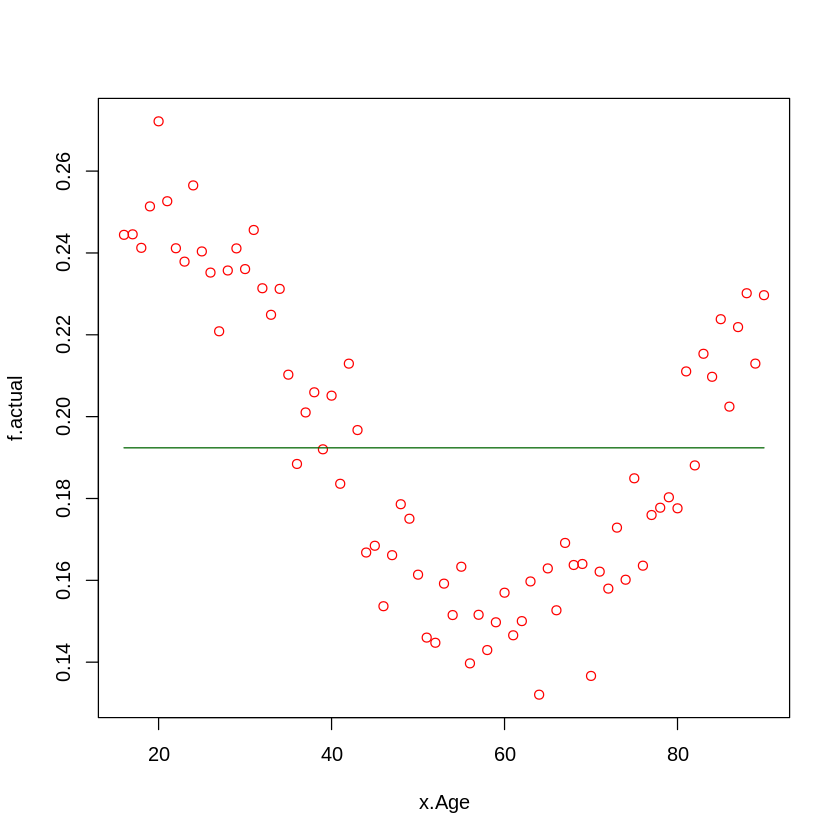

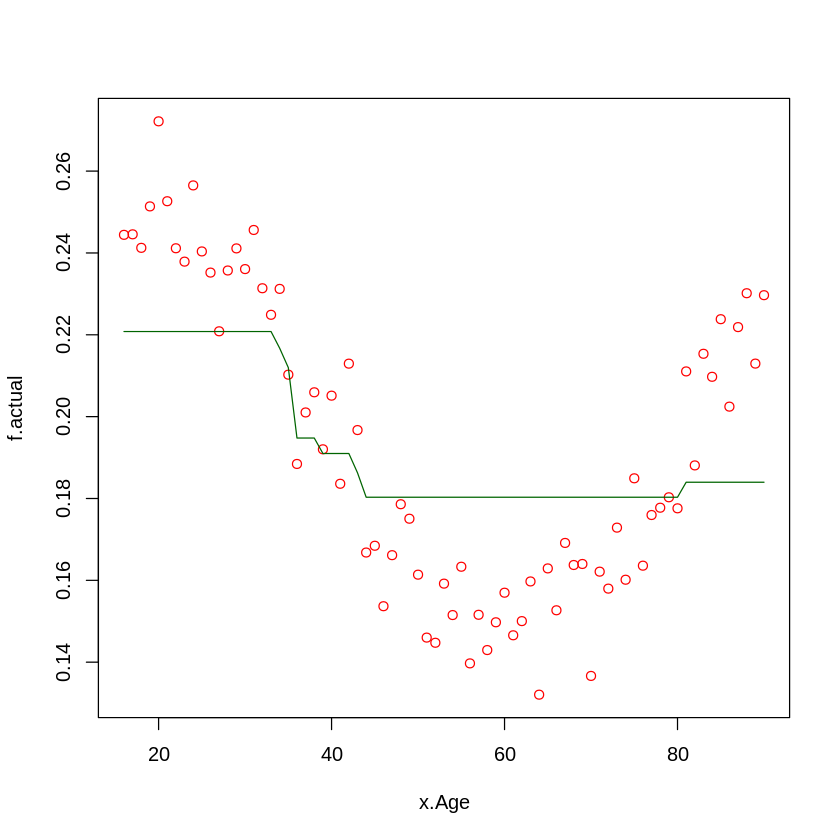

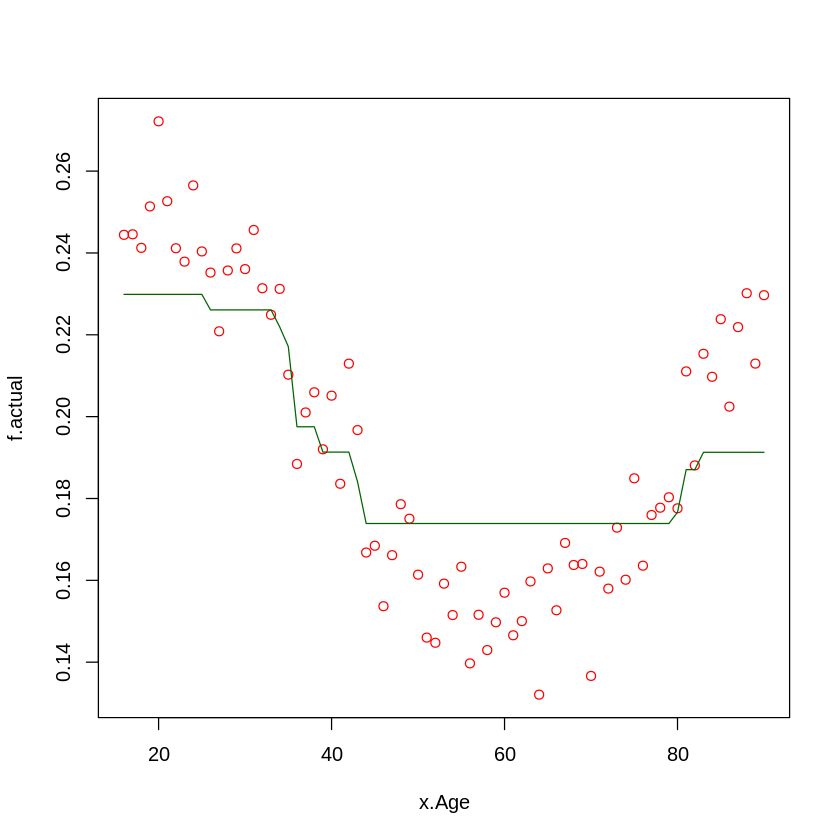

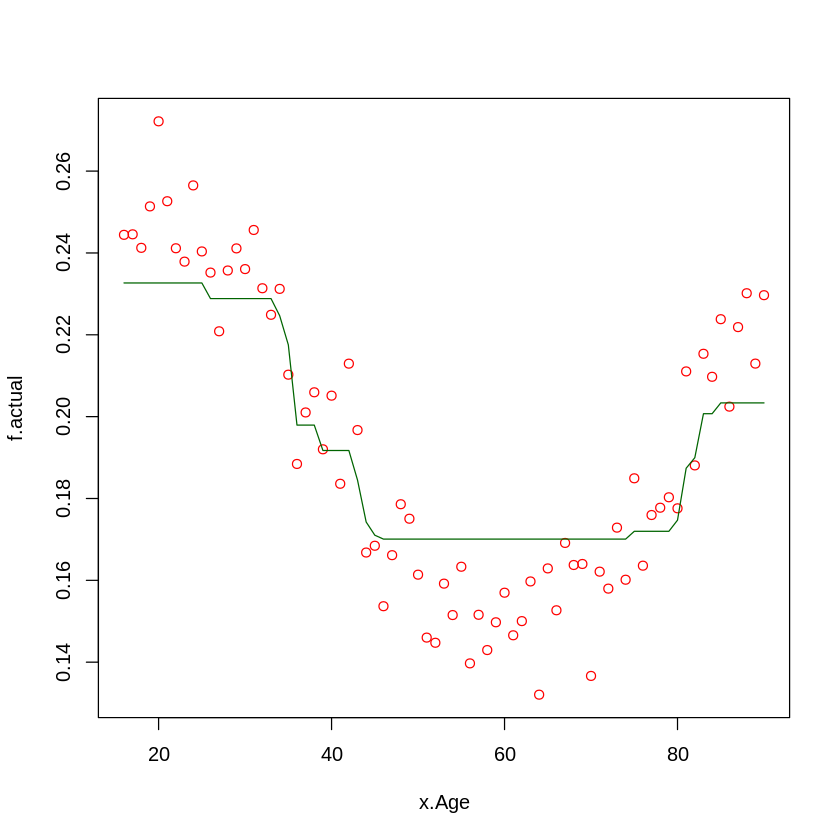

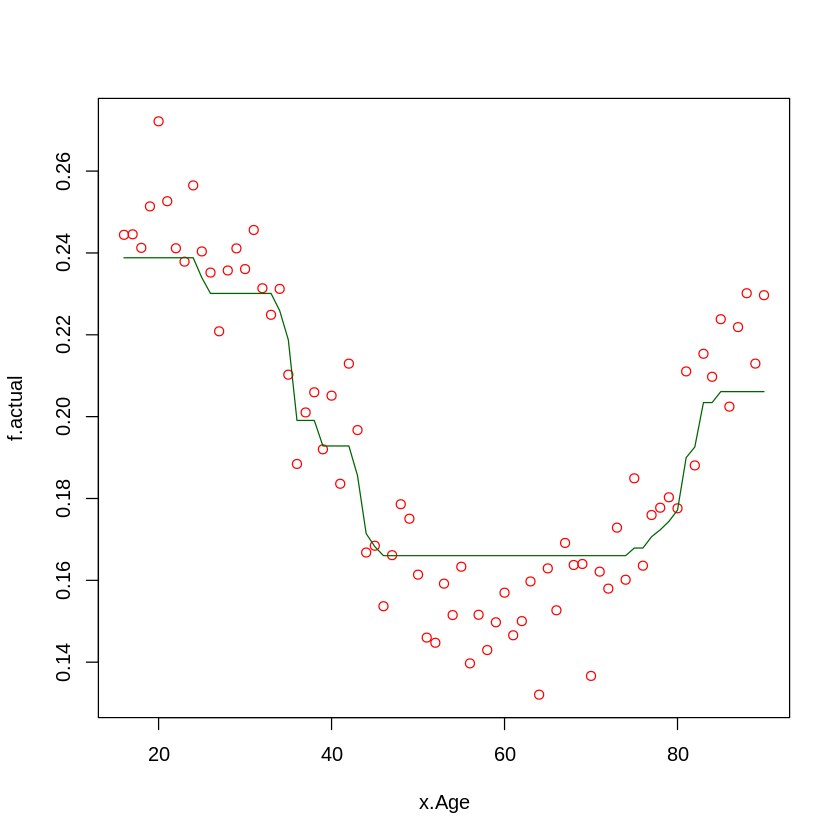

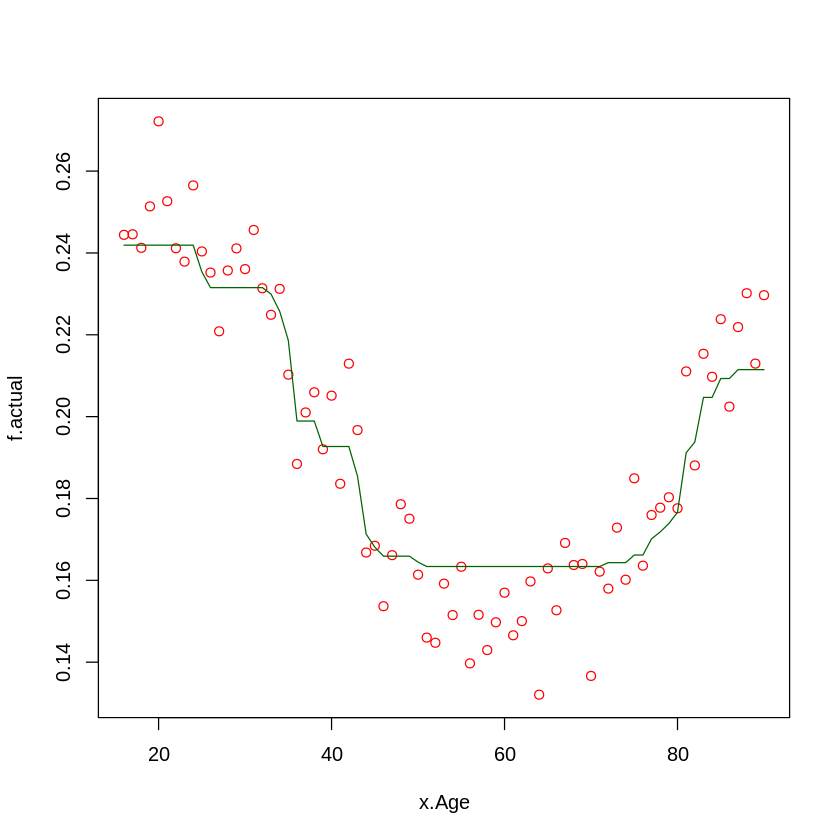

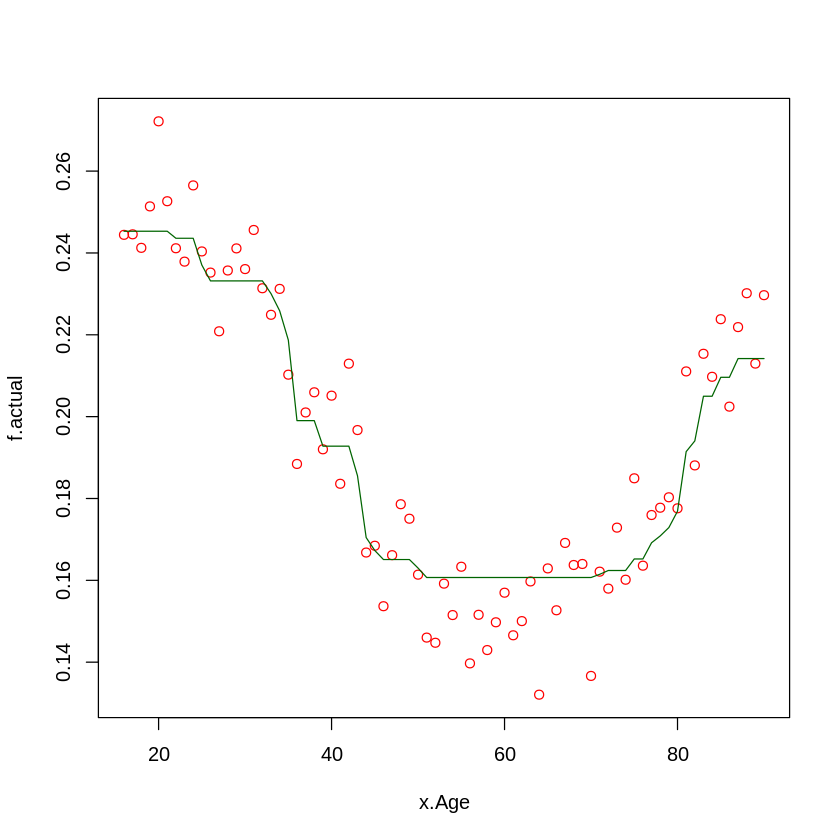

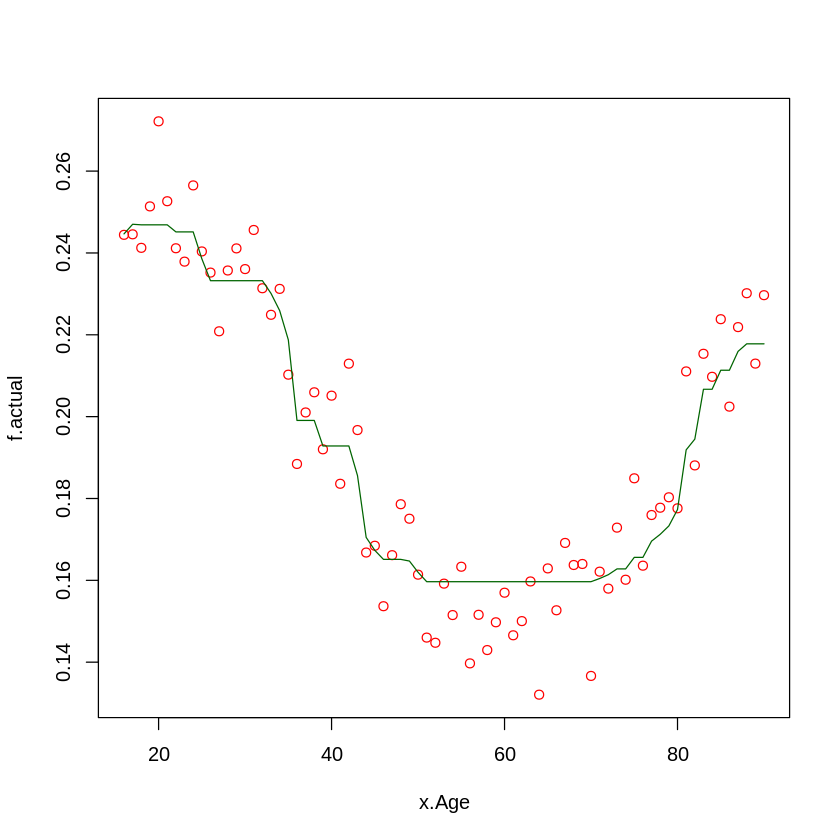

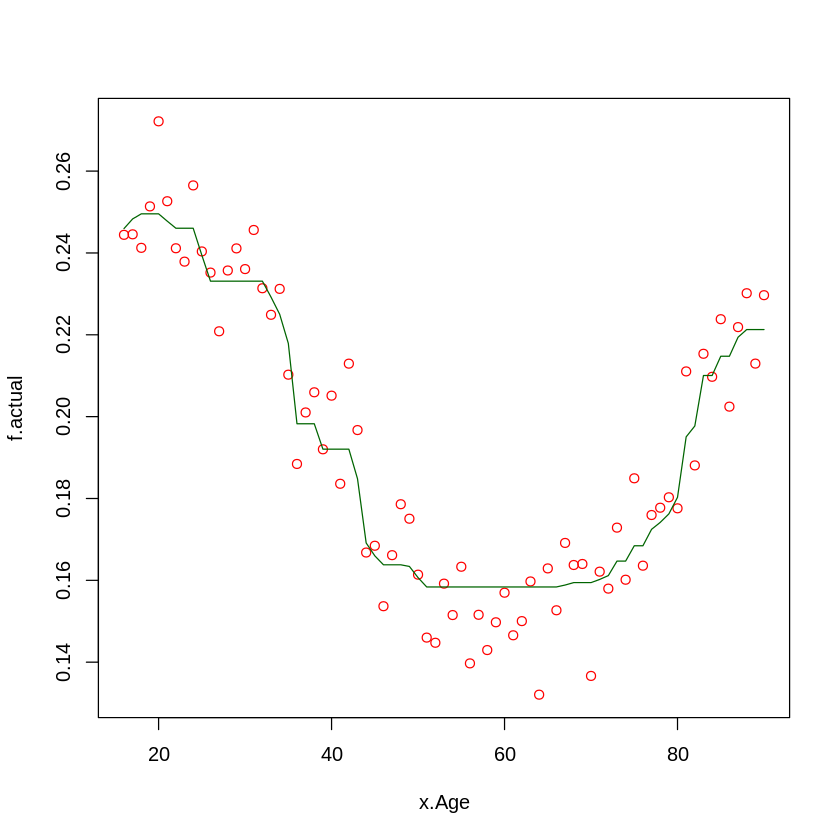

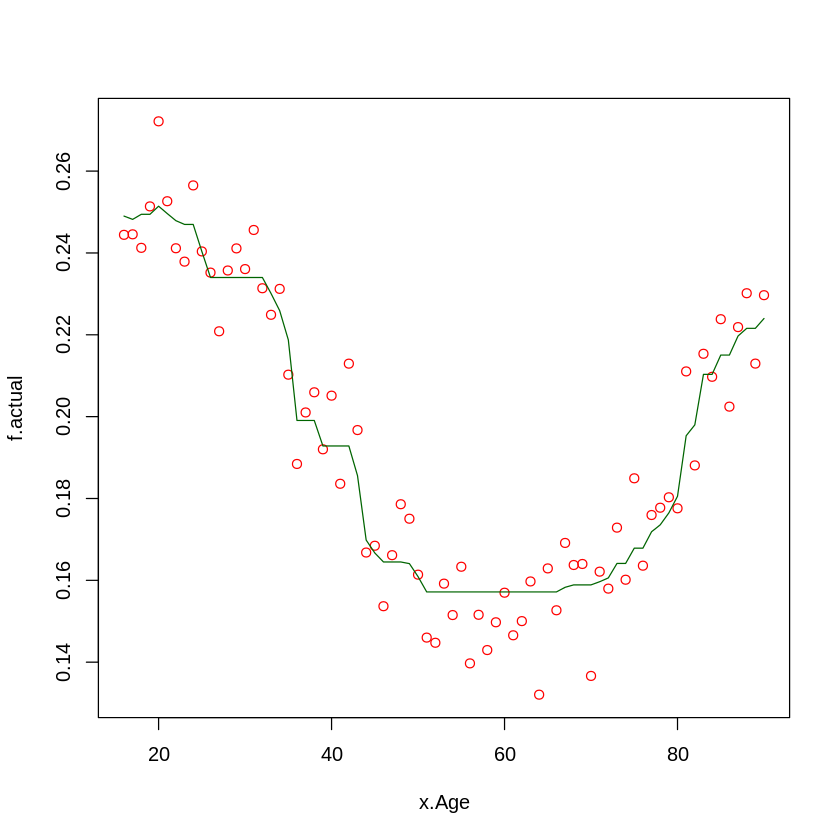

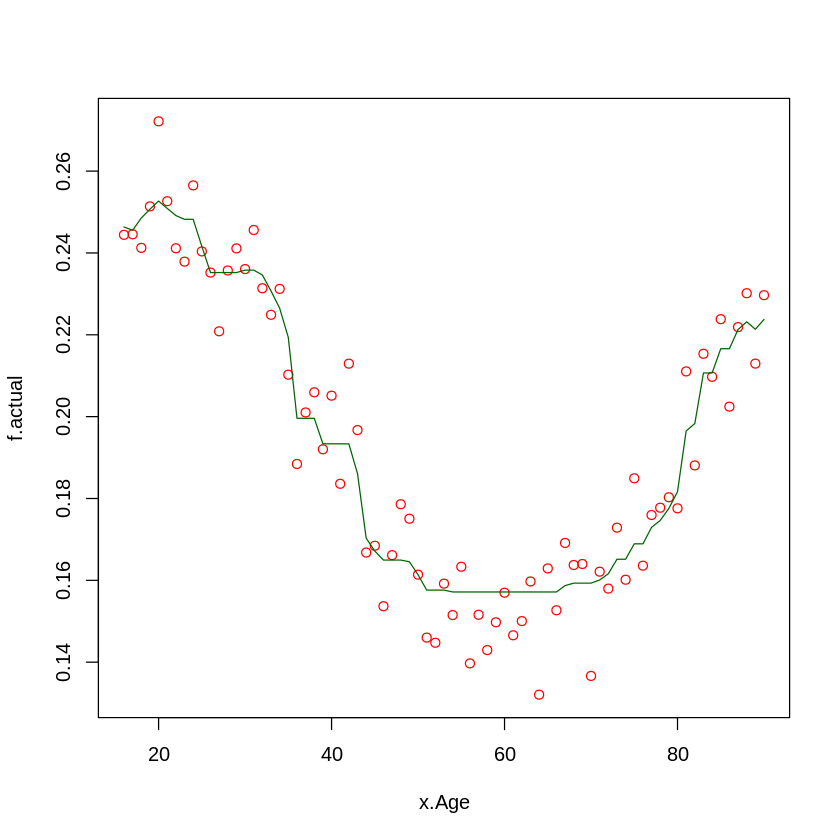

In [ ]:
with(df2, plot(x.Age, f.actual, col="red"))
for (i in seq(0, 100, 10)) {
  df2$f.pred.gbm.iter <- predict(m.gbm, newdata=df2, type="response", n.trees=i)
  with(df2, plot(x.Age, f.actual, col="red"))
  with(df2, lines(x.Age, f.pred.gbm.iter, col="darkgreen"))
}

# Evaluate Results

Lift Charts are a particular case of the Actual vs Expected plots. Instead of a variable, we line up the information based on the predicted responses. We then bin and check Actual vs Expected in the bins.

As we are evaluating results, let's turn our attention to the test data going forward.

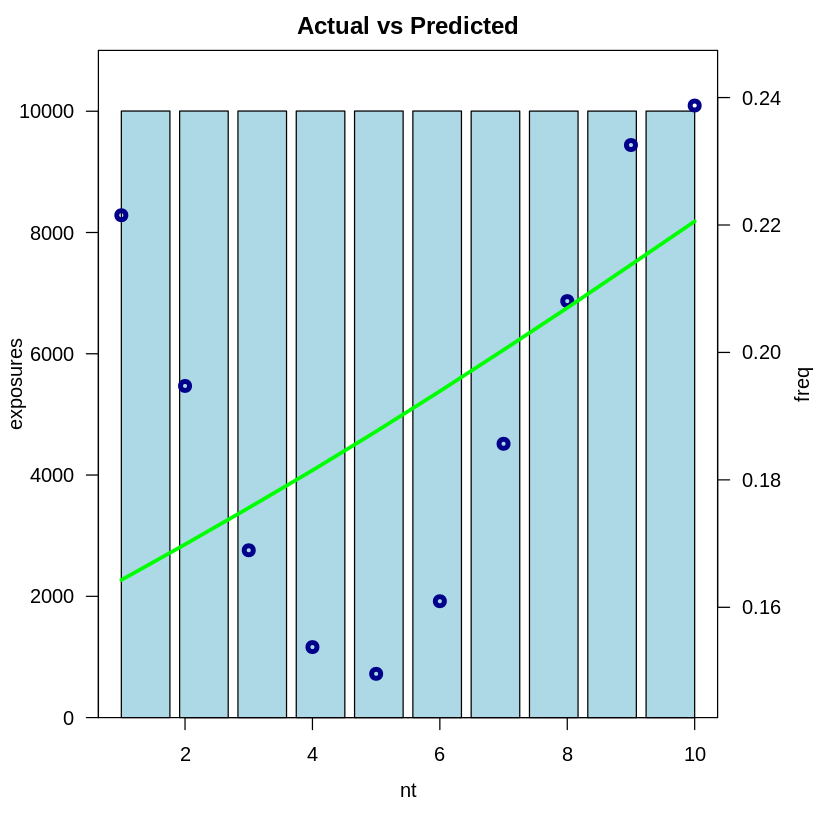

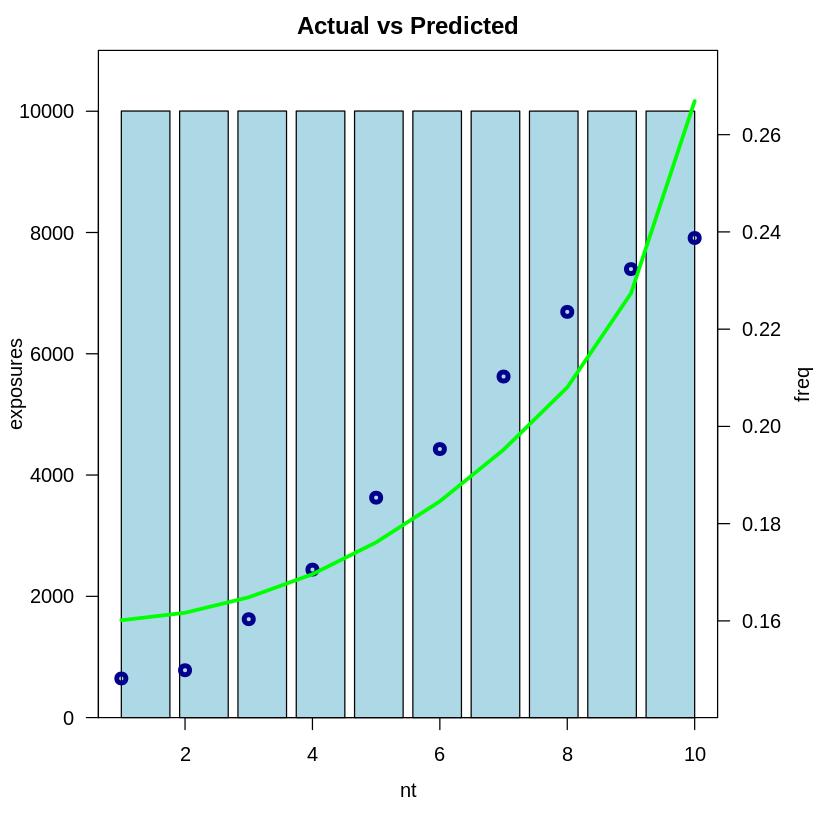

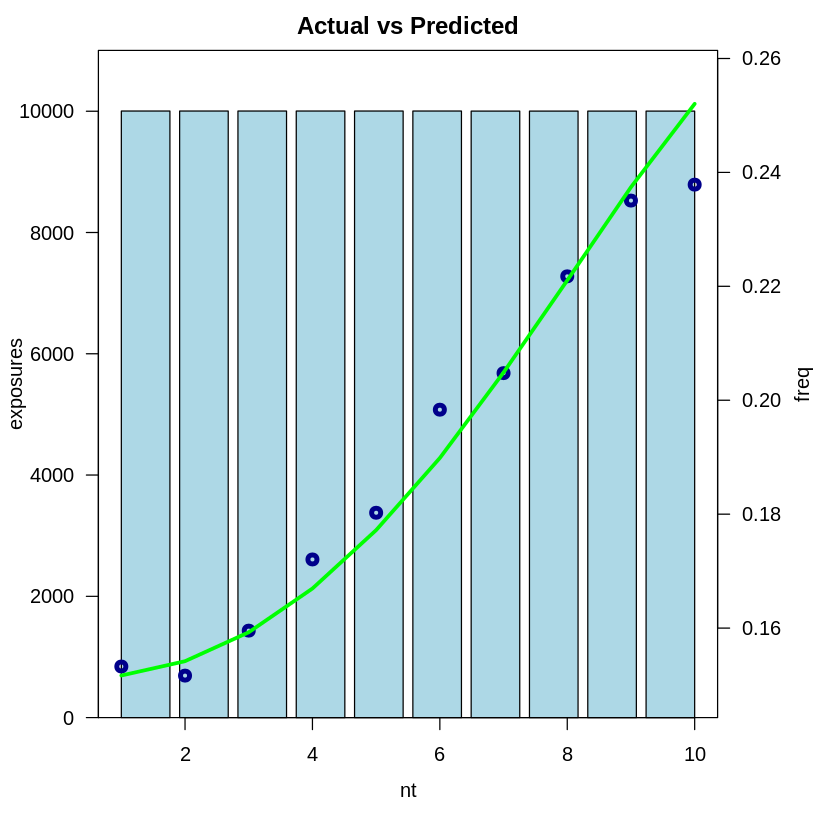

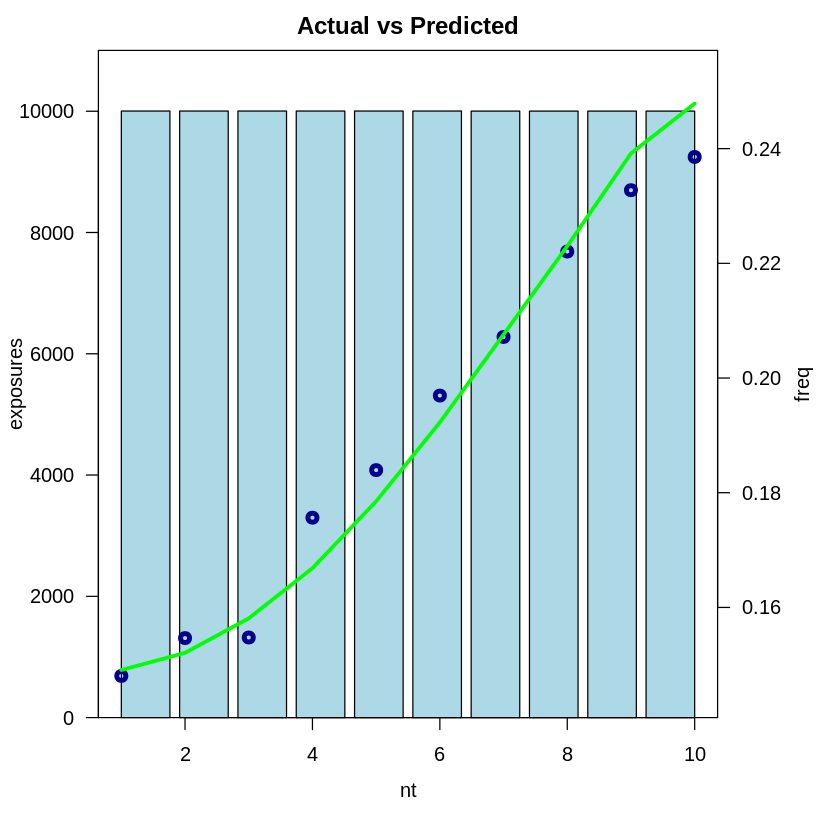

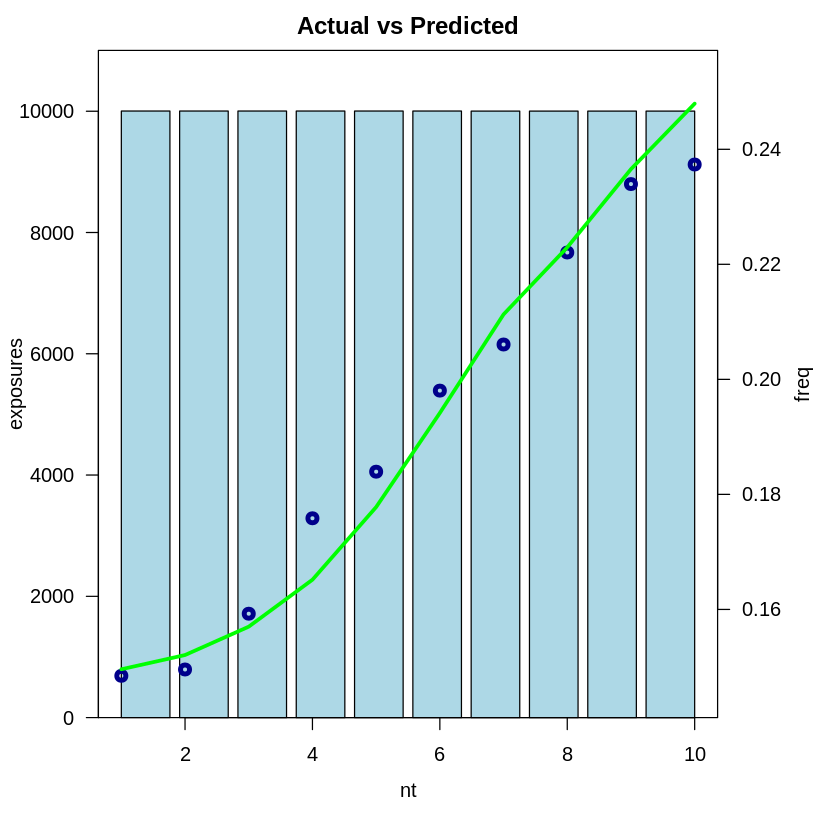

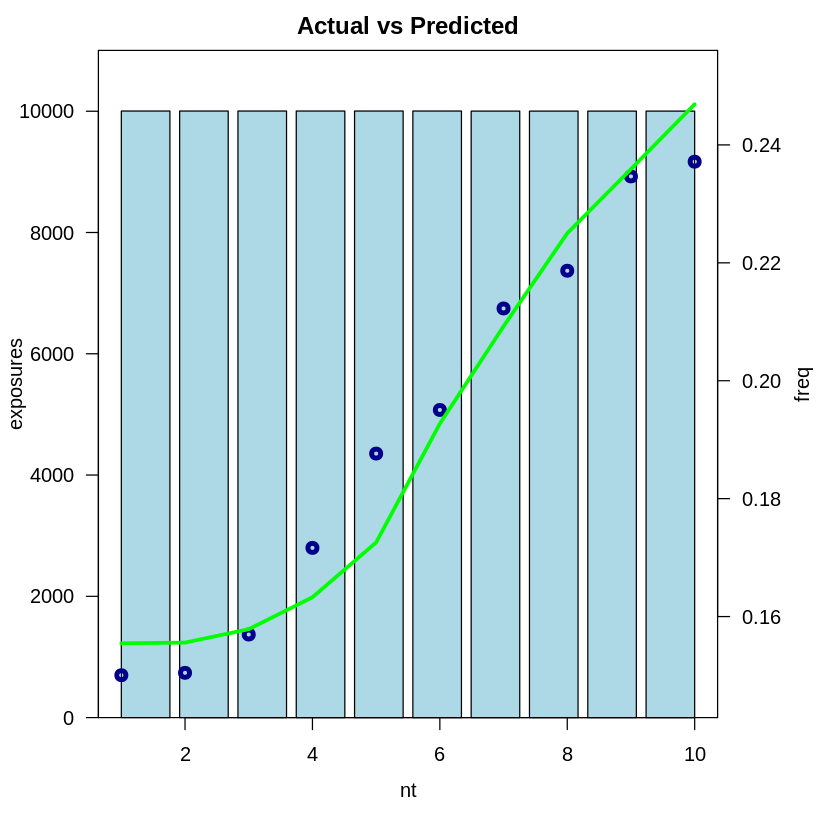

In [ ]:
df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm2, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm2",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm3, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm3",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm4, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm4",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm9, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm9",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.gbm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.gbm",weight="exposures",lt_text="exposures",rt_text="freq")

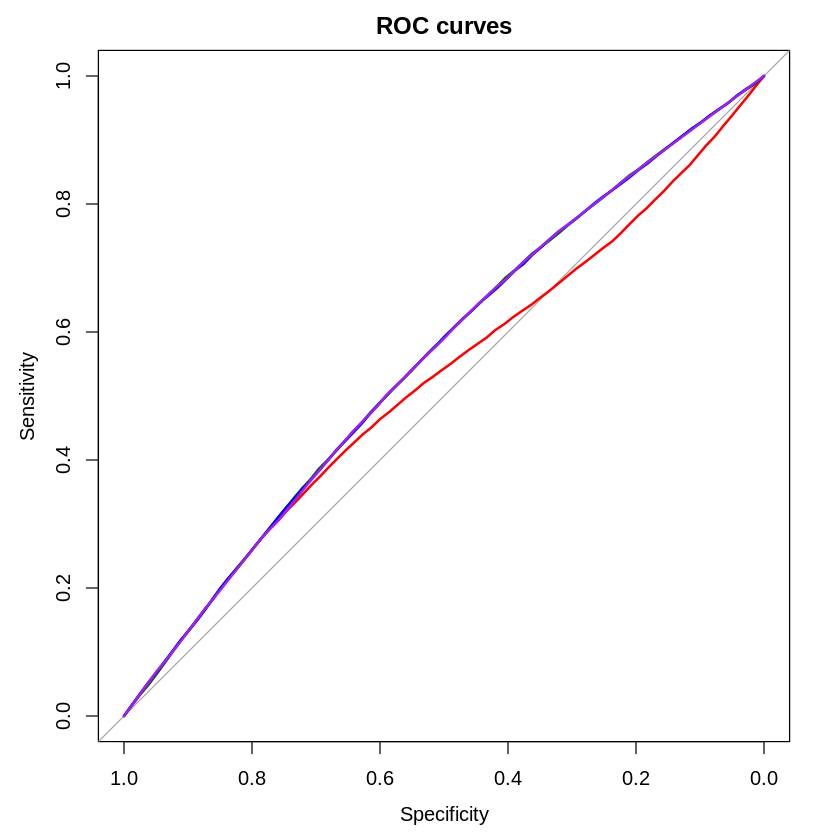

In [ ]:
quiet.setting <- TRUE

roc.score.glm <- roc(y.test, df.test$y.pred.glm, quiet = quiet.setting)
plot(roc.score.glm, main ="ROC curves", col = "red")

roc.score.glm2 <- roc(y.test, df.test$y.pred.glm2, quiet = quiet.setting)
plot(roc.score.glm2, col = "darkgreen", add = TRUE)

roc.score.glm4 <- roc(y.test, df.test$y.pred.glm4, quiet = quiet.setting)
plot(roc.score.glm4, col = "blue", add = TRUE)

roc.score.gbm <- roc(y.test, df.test$y.pred.gbm, quiet = quiet.setting)
plot(roc.score.gbm, col = "purple", add = TRUE)

Since the ROC plots for GLM2, GLM4 and GBM all sit on top of each other, I expect the AUC's (area under ROC curve) to be comparable. Gini's are computed to be 2xAUC - 1, and I expect Gini's to behave similarly.

In [ ]:
model.name <- c("GLM", "GLM2", "GLM4", "GBM")
quiet.setting <- TRUE
model.train.auc <- c( auc(y.train, df.train$y.pred.glm, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.glm2, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.glm4, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.gbm, quiet = quiet.setting))
model.train.gini <- 2*model.train.auc - 1
model.test.auc <- c(auc(y.test, df.test$y.pred.glm, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.glm2, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.glm4, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.gbm, quiet = quiet.setting))
model.test.gini <- 2*model.test.auc - 1
data.frame(model.name, model.train.auc, model.train.gini, model.test.auc, model.test.gini)

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5335765,0.06715307,0.5233374,0.04667484
GLM2,0.5634076,0.12681514,0.5595293,0.11905866
GLM4,0.5637789,0.12755777,0.5592600,0.11852004
GBM,0.5646292,0.12925844,0.5590903,0.11818061


**Transition from GBM to XGBOOST**

Going forward, we are going to shift to xgboost. For those interested, note gbm is a good function to get comfortable with, and is particularly useful for smaller scale modeling. Typically I would still label these as gbm. For this workshop, I shall incorporate instead xgb, to differentiate work done with gbm from work done with xgboost.

In [ ]:
set.seed(031302)
m.xgb <- xgboost(data = as.matrix(x.train),
                  label = y.train,
                  verbose = 0,
                  nrounds = 100,                  #number of trees, defaulat is 100
                  eta = 0.3,                      #learning rate, default is 0.3
                  max_depth = 6,                  #depth of tree, default is 6
                  min_child_weight = 1,           #size of child node, default is 1
                  subsample = 1,                  #sample of data used for each iteration, default is 1
                  colsample_bytree = 1,           #pct of features for each iteration, default is 1
                  objective = "binary:logistic",  #prediction objective
                  eval_metric = "auc")

In [ ]:
df.train$y.pred.xgb <- predict(m.xgb, newdata=as.matrix(x.train))
df.test$y.pred.xgb <- predict(m.xgb, newdata=as.matrix(x.test))
df2$f.pred.xgb <- predict(m.xgb, newdata=as.matrix(df2$x.Age))

In [ ]:
model.name <- c("GLM", "GLM2", "GLM4", "GBM", "XGB")
quiet.setting <- TRUE
model.train.auc <- c( auc(y.train, df.train$y.pred.glm, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.glm2, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.glm4, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.gbm, quiet = quiet.setting),
                      auc(y.train, df.train$y.pred.xgb, quiet = quiet.setting))
model.train.gini <- 2*model.train.auc - 1
model.test.auc <- c(auc(y.test, df.test$y.pred.glm, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.glm2, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.glm4, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.gbm, quiet = quiet.setting),
                    auc(y.test, df.test$y.pred.xgb, quiet = quiet.setting))
model.test.gini <- 2*model.test.auc - 1
data.frame(model.name, model.train.auc, model.train.gini, model.test.auc, model.test.gini)

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5335765,0.06715307,0.5233374,0.04667484
GLM2,0.5634076,0.12681514,0.5595293,0.11905866
GLM4,0.5637789,0.12755777,0.5592600,0.11852004
GBM,0.5646292,0.12925844,0.5590903,0.11818061
XGB,0.5669188,0.13383765,0.5569632,0.11392634


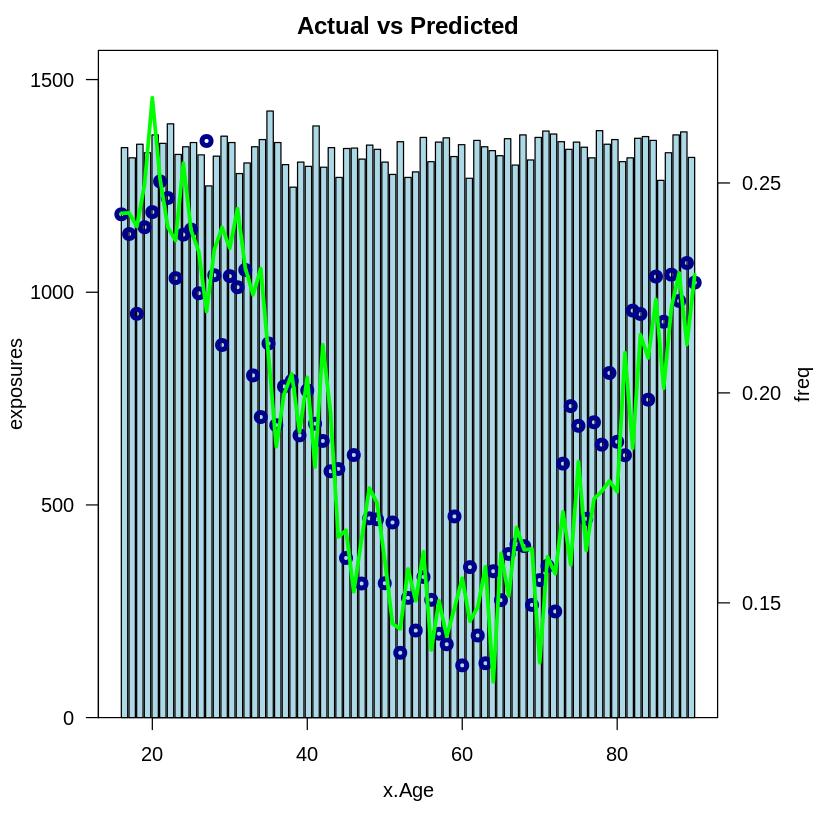

In [ ]:
avse.plot.classification(var="x.Age",data=df.test,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

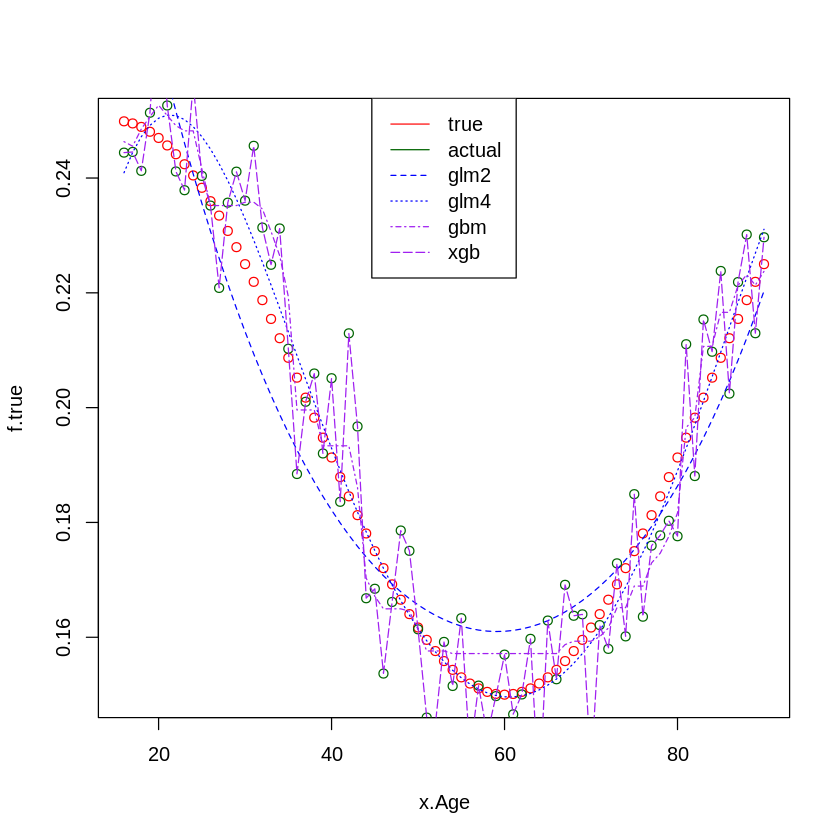

In [ ]:
with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))
with(df2, lines(x.Age, f.pred.glm2, lty = 2, col="blue"))
with(df2, lines(x.Age, f.pred.glm4, lty = 3, col="blue"))
with(df2, lines(x.Age, f.pred.gbm, lty = 4, col="purple"))
with(df2, lines(x.Age, f.pred.xgb, lty = 5, col="purple"))
legend("top",
       legend=c("true", "actual", "glm2", "glm4", "gbm", "xgb"),
       lty=c(1,1,2:5),
       col=c("red", "darkgreen", "blue", "blue", "purple", "purple"))

# Simulate Data - A More Interesting Example

Now, we're going to take the xgboost for a test drive. Our simulated example above is nice for an introduction, but is too trivial for deeper play. Let's put something together a bit closer to what we would typically run.

For explorations, we will create the following data:
*   Age
*   Gender (y-correlated with Age)
*   Marital Status (exposure correlated with Age)
*   Tenure (some correlation with age)
*   Territory (Urban and Rural)
*   Vehicle Type (Sedan, Minivan, Trucks, Other - some correlation with Marital Status and Territory)
*   V1 - V9 (9 generic variables of various correlations with each other and with response)


In [ ]:
sim_file_github <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Sim_Data_CASRPM2023.csv"
df <- read.csv(file=sim_file_github, header=TRUE)

In [ ]:
#A space to look at the data
summary(df)

     x.Age         x.Gender.M    x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:36.00   1st Qu.:0.000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.000   Median :1.0000    Median : 5.000  
 Mean   :53.02   Mean   :0.499   Mean   :0.5495    Mean   : 6.024  
 3rd Qu.:70.00   3rd Qu.:1.000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2            x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.00   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.00   1st Qu.: 7.0  
 Median :0.0000   Median : 6.000   Median : 5.00   Median :11.0  
 Mean   :0.2005   Mean   : 5.506   Mean   : 5.49   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.00   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.00   Max.   :20.0  
      x.V4             x.V5             x.V6           x.V7   

In [ ]:
set.seed(031303)
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.8,0.2))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [ ]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]
df.train$exposures <- 1

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]
df.test$exposures <- 1

**Quick Look at the Data**

It's good to take a look at the data and see what we think about what we have.

In [ ]:
colnames(df.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"  
[19] "y.truth"               "y.out"                 "exposures"

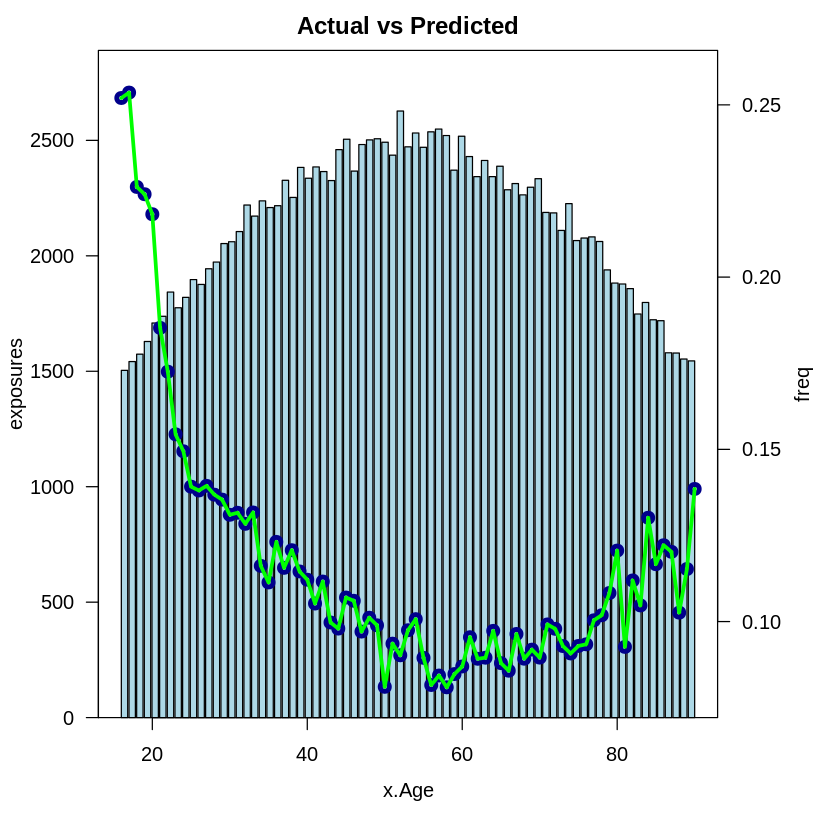

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.out",weight="exposures",lt_text="exposures",rt_text="freq")

In [ ]:

m.xgb <- xgboost(data = as.matrix(x.train),
                  label = y.train,
                  verbose = 0,
                  nrounds = 100,                  #number of trees, defaulat is 100
                  eta = 0.3,                      #learning rate, default is 0.3
                  max_depth = 6,                  #depth of tree, default is 6
                  subsample = 1,                  #sample of data used for each iteration, default is 1
                  colsample_bytree = 1,           #pct of features for each iteration, default is 1
                  objective = "binary:logistic")  #prediction objective

y.pred.train <- predict(m.xgb, newdata=as.matrix(x.train), type="response")
y.pred.test <- predict(m.xgb, newdata=as.matrix(x.test), type="response")

In [ ]:
df.train$y.pred.xgb <- y.pred.train
df.test$y.pred.xgb <- y.pred.test

Let's take a look at how we did.

**Lift Table**

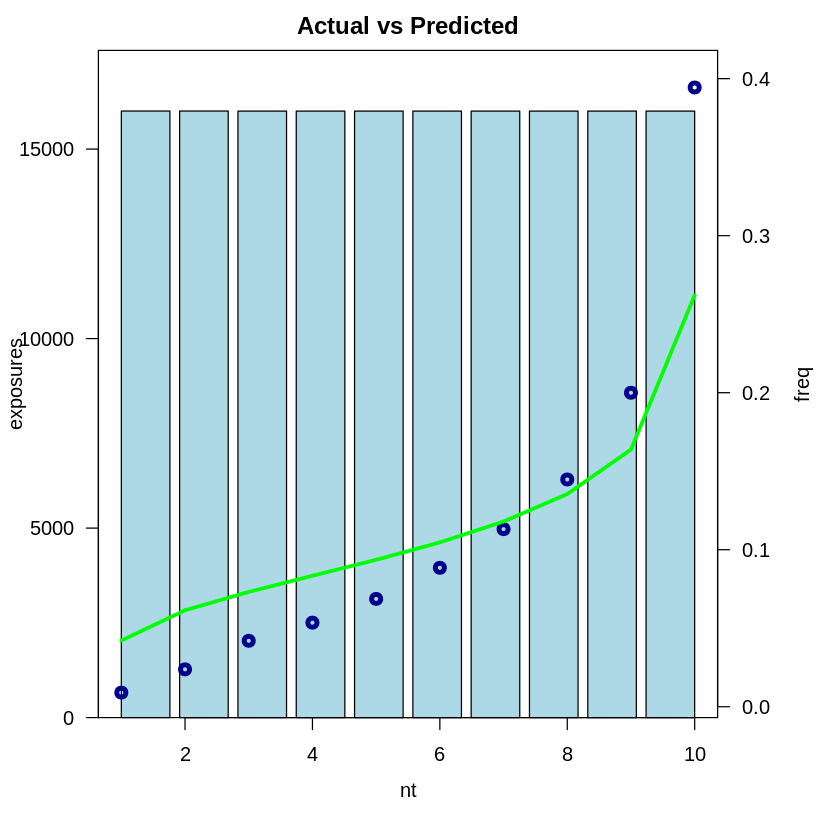

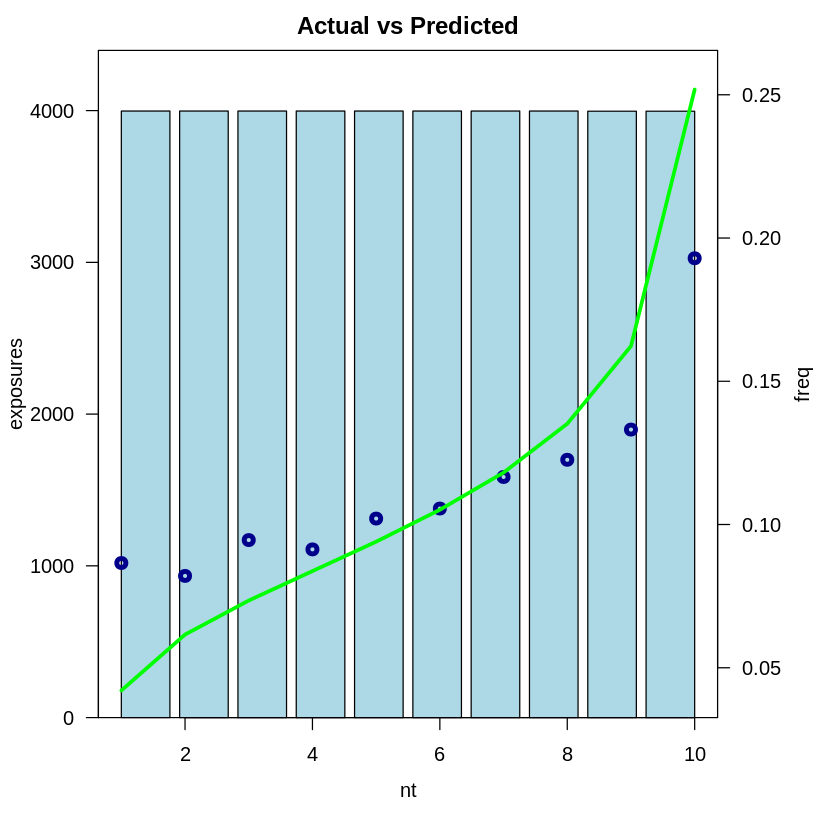

In [ ]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.xgb, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.xgb, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

**ROC, AUC and GINI**

We're going to use/stack the statline info repeatedly. This is a good time to make that a function.

In [ ]:
build_statline = function(y.train, y.train.pred, y.test, y.test.pred, model.name) {
  quiet.setting <- TRUE
  model.train.auc <- c(auc(y.train, y.train.pred, quiet = quiet.setting))
  model.train.gini <- 2*model.train.auc - 1
  model.test.auc <- c(auc(y.test, y.test.pred, quiet = quiet.setting))
  model.test.gini <- 2*model.test.auc - 1
  return(data.frame(model.name, model.train.auc, model.train.gini, model.test.auc, model.test.gini))
}

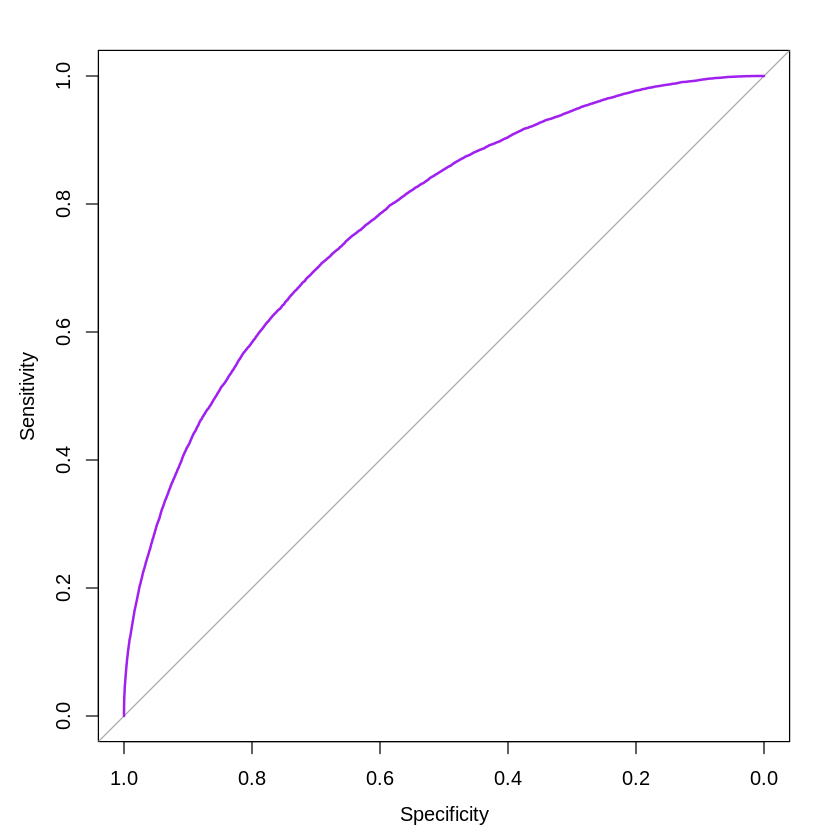

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
XGB,0.7747078,0.5494156,0.5787829,0.1575658


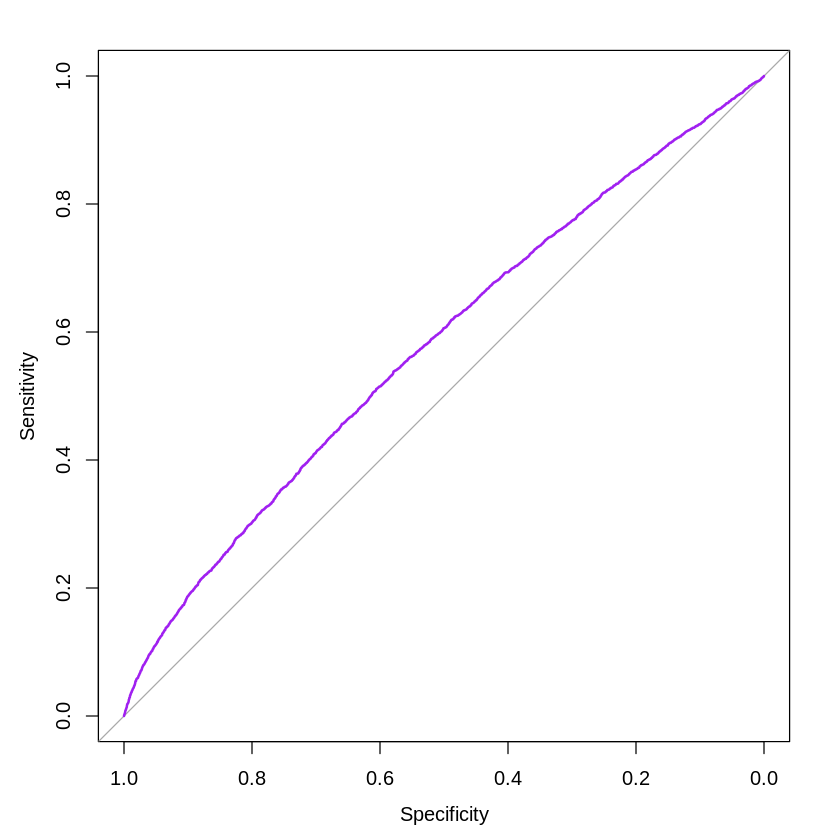

In [ ]:
roc.score.train.xgb <- roc(y.train, df.train$y.pred.xgb, quiet = quiet.setting)
plot(roc.score.train.xgb, col = "purple", add = FALSE)

roc.score.test.xgb <- roc(y.test, df.test$y.pred.xgb, quiet = quiet.setting)
plot(roc.score.test.xgb, col = "purple", add = FALSE)

statline.xgb <- build_statline(y.train, df.train$y.pred.xgb, y.test, df.test$y.pred.xgb, "XGB")
statline.xgb

**A vs E plots**

In [ ]:
colnames(df.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"  
[19] "y.truth"               "y.out"                 "exposures"            
[22] "y.pred.xgb"            "nt"

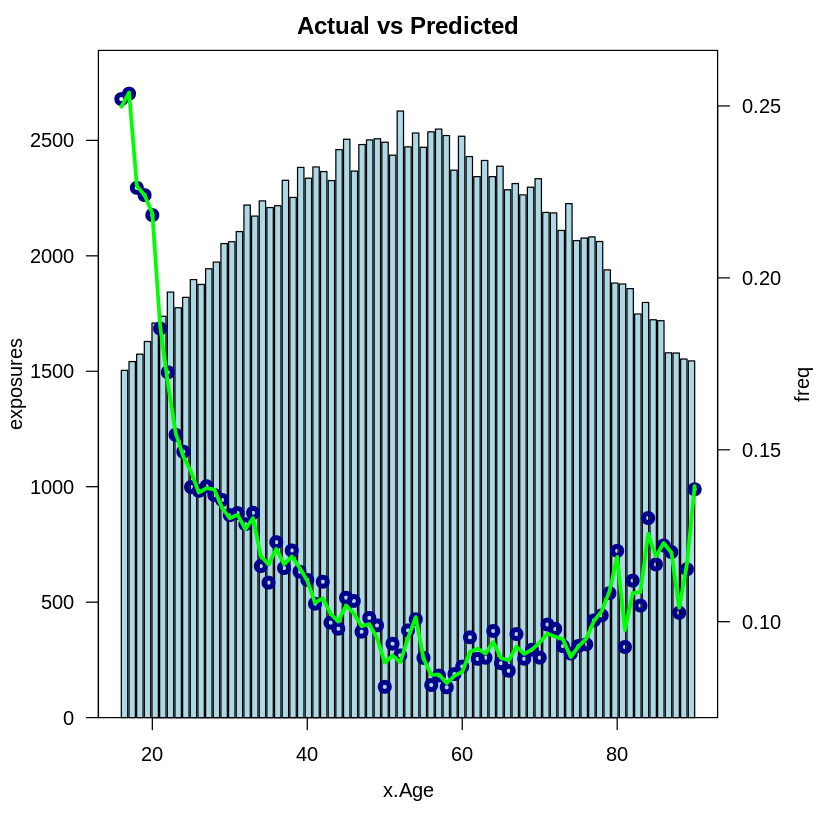

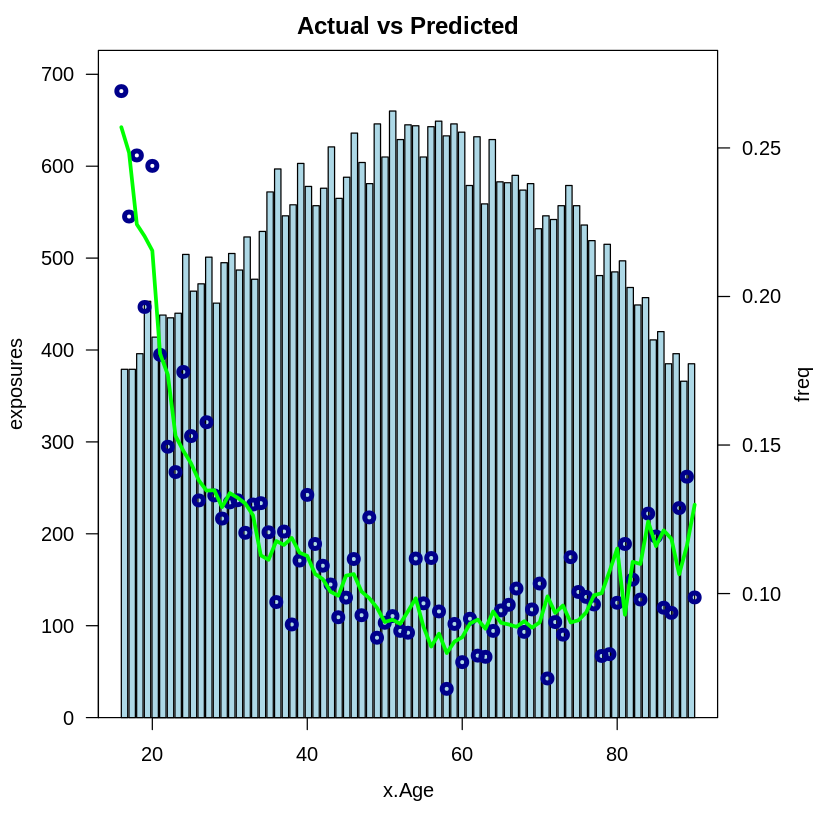

In [ ]:
var.curr = "x.Age"
avse.plot.classification(var=var.curr,data=df.train,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.test,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

**Variable Importance**
With more variables, now it is interesting to consider what the model says are the important variables. And the package supplies a view for us.

In [ ]:
importance_matrix <- xgb.importance(colnames(x.train), model = m.xgb)
importance_matrix

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
x.Age,0.206969339,0.196372024,0.142663733
x.Tenure,0.091832597,0.127214970,0.092570655
x.V3,0.084368087,0.098333824,0.095616856
x.V9,0.079863668,0.083081161,0.093078355
x.V6,0.075077038,0.082567880,0.087324420
x.V1,0.072670973,0.059572536,0.077170418
x.V2,0.064316656,0.058167026,0.067524116
x.V4,0.058679294,0.054792792,0.067354882
x.V8,0.058395813,0.048953690,0.069216449


Before we move on to playing (hypertuning) and improving our GBM, let's take a moment and see where our GLM starting point is. If you get annoyed by the warning below you'll want to remove one of the VehicleType variables.

In [ ]:
m.glm <- glm(y.train ~ ., x.train, family=binomial(link='logit'))
df.train$y.pred.glm <- predict(m.glm, newdata=x.train, type="response")
df.test$y.pred.glm <- predict(m.glm, newdata=x.test, type="response")
summary(m.glm)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”



Call:
glm(formula = y.train ~ ., family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8332  -0.5260  -0.4645  -0.4023   2.5641  

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.9664637  0.0514086 -38.252  < 2e-16 ***
x.Age                 -0.0068577  0.0004608 -14.881  < 2e-16 ***
x.Gender.M             0.1214298  0.0158618   7.656 1.93e-14 ***
x.MaritalStatus.M     -0.2109414  0.0205605 -10.260  < 2e-16 ***
x.Tenure              -0.0330195  0.0016497 -20.015  < 2e-16 ***
x.Territory.U          0.3066902  0.0191634  16.004  < 2e-16 ***
x.V1                   0.0365721  0.0027620  13.241  < 2e-16 ***
x.V2                   0.0259867  0.0037286   6.970 3.18e-12 ***
x.V3                   0.0078966  0.0025022   3.156   0.0016 ** 
x.V4                   0.0121679  0.0027608   4.407 1.05e-05 ***
x.V5                   0.

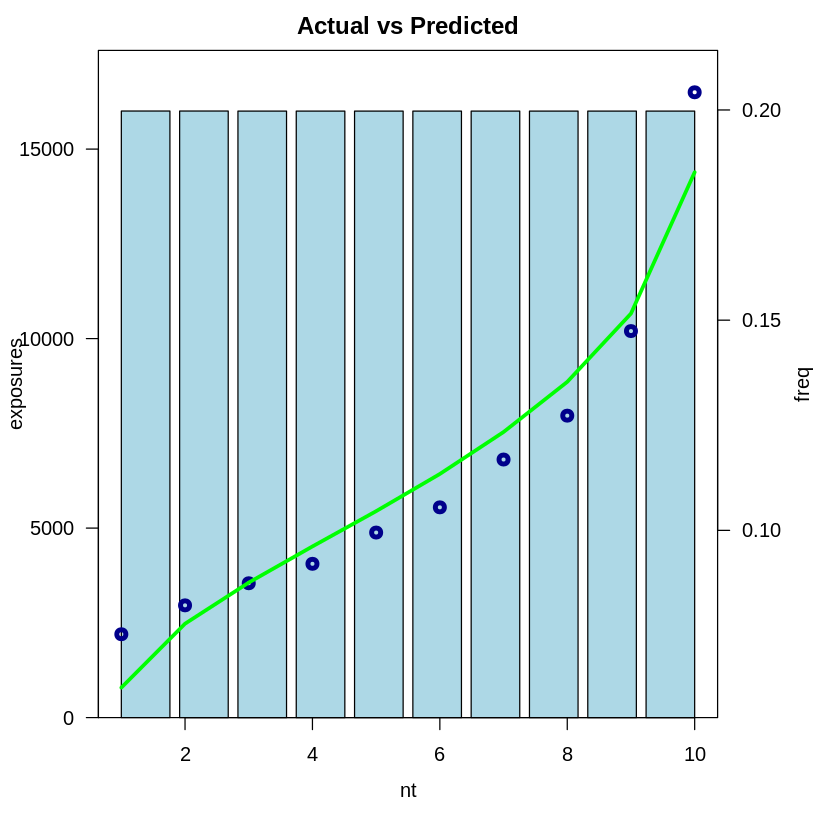

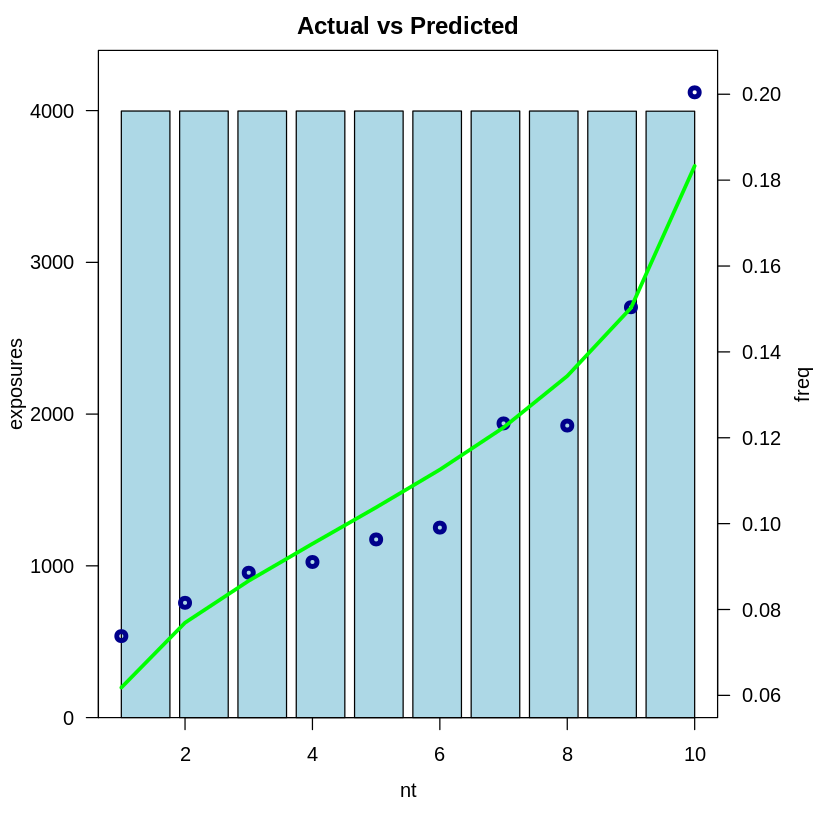

In [ ]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

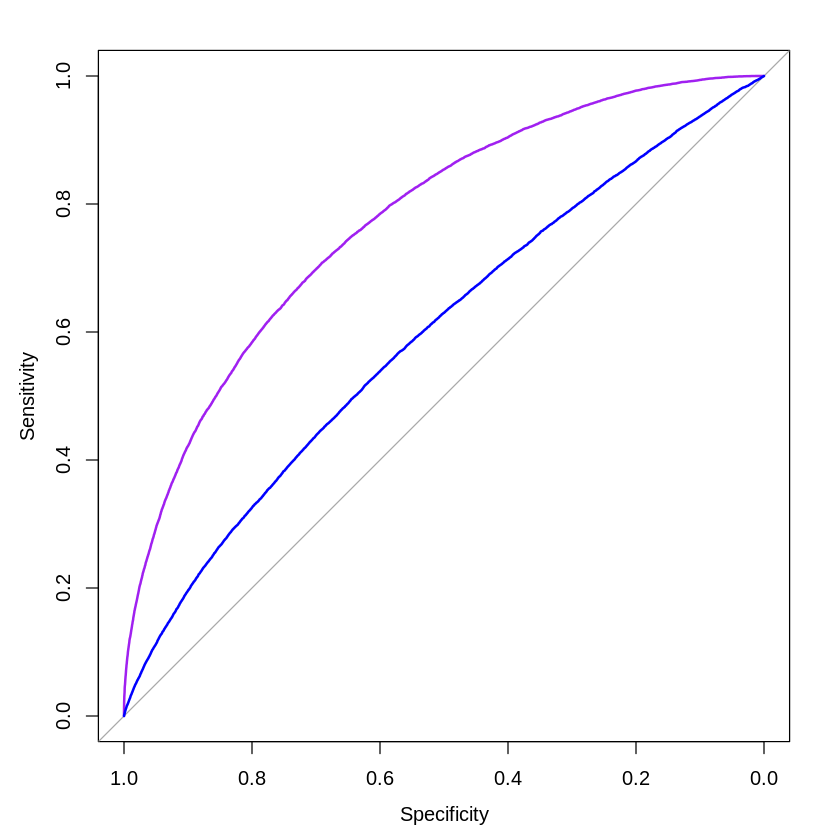

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5957808,0.1915615,0.5966333,0.1932665
XGB,0.7747078,0.5494156,0.5787829,0.1575658


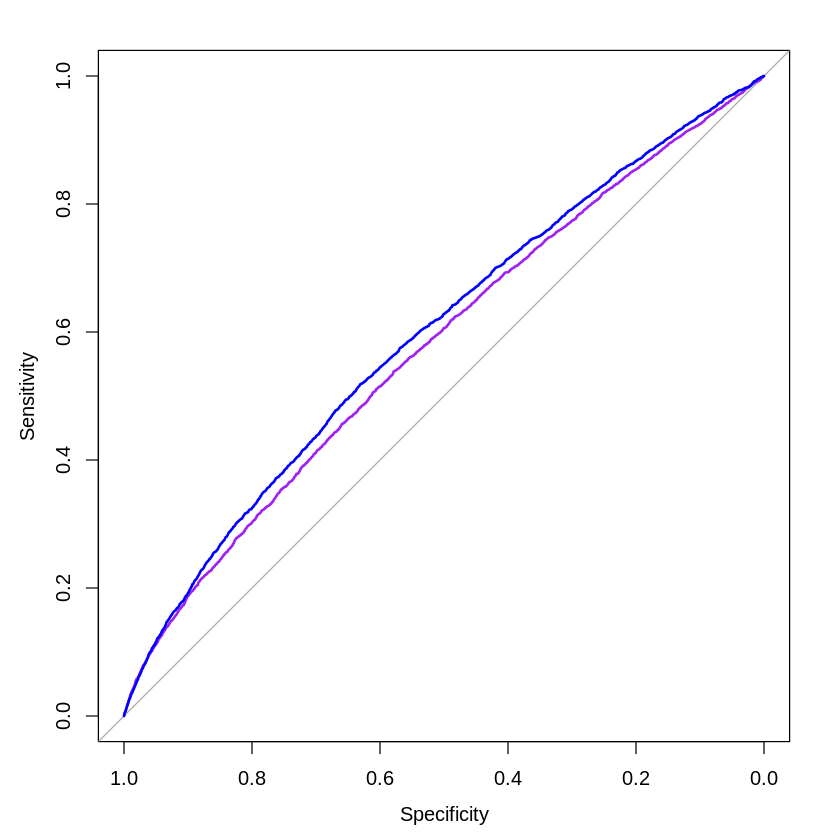

In [ ]:
quiet.setting = TRUE
roc.score.xgb <- roc(y.train, df.train$y.pred.xgb, quiet = quiet.setting)
roc.score.glm <- roc(y.train, df.train$y.pred.glm, quiet = quiet.setting)
plot(roc.score.xgb, col = "purple", add = FALSE)
plot(roc.score.glm, col = "blue", add = TRUE)

roc.score.xgb <- roc(y.test, df.test$y.pred.xgb, quiet = quiet.setting)
roc.score.glm <- roc(y.test, df.test$y.pred.glm, quiet = quiet.setting)
plot(roc.score.xgb, col = "purple", add = FALSE)
plot(roc.score.glm, col = "blue", add = TRUE)

statline.glm <- build_statline(y.train, df.train$y.pred.glm, y.test, df.test$y.pred.glm, "GLM")
statline.all <- rbind(statline.glm, statline.xgb)
statline.all

In [ ]:
colnames(x.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"

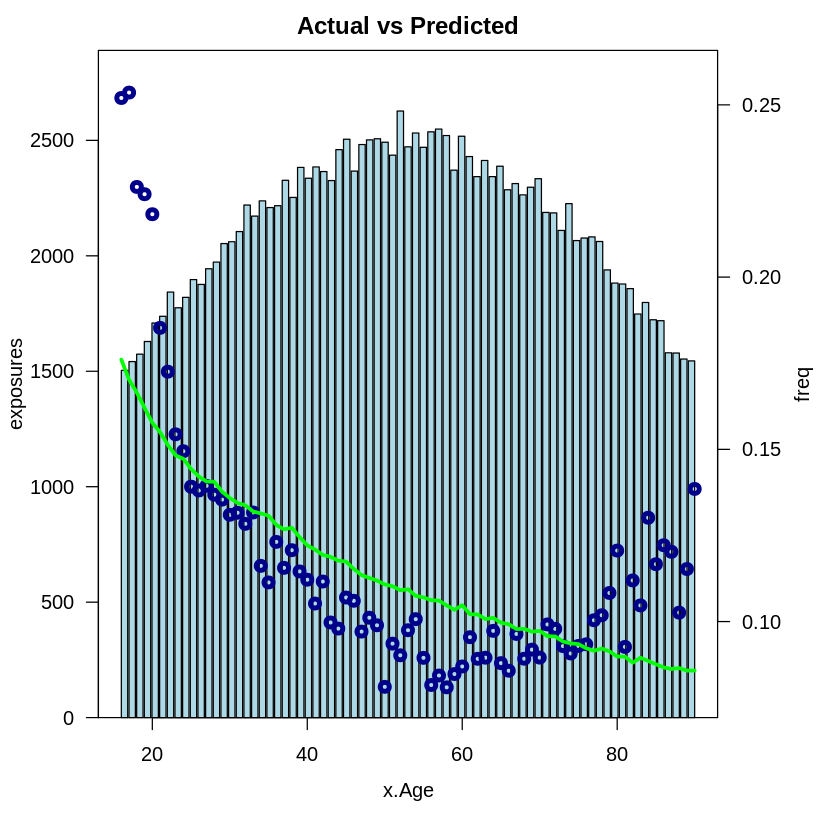

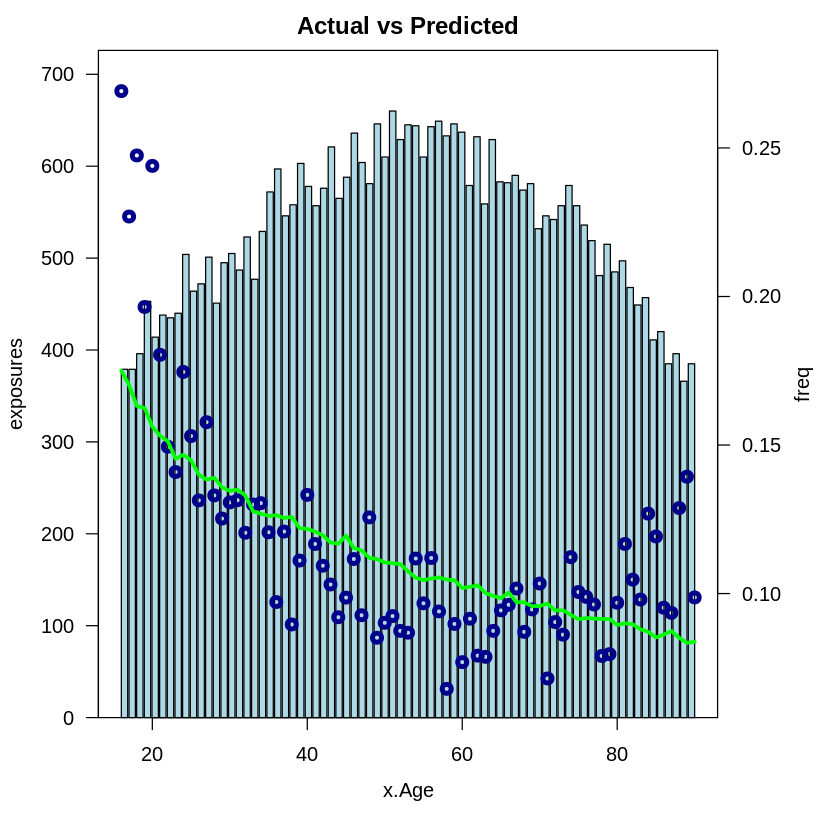

In [ ]:
var.curr = "x.Age"
avse.plot.classification(var=var.curr,data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

# Improve on the GBM - Hyperparameters and Tuning

We can improve on the GLM, but we won't. What we will do here is improve on this preliminary XGBoost, ideally without too much additional work.

In [ ]:
params = list(eta=0.3,
  max_depth=6,
  subsample=1,
  colsample_bytree=1)
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 100,
  nfold = 5,
  showsd = TRUE,
  print_every_n = 10,
  early_stop_round = 20)

[1]	train-logloss:0.538676+0.000585	test-logloss:0.539213+0.001150 
[11]	train-logloss:0.341002+0.001429	test-logloss:0.347268+0.005560 
[21]	train-logloss:0.334859+0.001582	test-logloss:0.347652+0.005749 
[31]	train-logloss:0.329931+0.001566	test-logloss:0.348624+0.005694 
[41]	train-logloss:0.325382+0.001587	test-logloss:0.349437+0.005830 
[51]	train-logloss:0.321188+0.001981	test-logloss:0.350361+0.005980 
[61]	train-logloss:0.316979+0.002164	test-logloss:0.351231+0.005972 
[71]	train-logloss:0.313060+0.002274	test-logloss:0.352077+0.005971 
[81]	train-logloss:0.309216+0.002208	test-logloss:0.353000+0.005939 
[91]	train-logloss:0.305477+0.002373	test-logloss:0.353873+0.006008 
[100]	train-logloss:0.302317+0.002163	test-logloss:0.354600+0.006057 


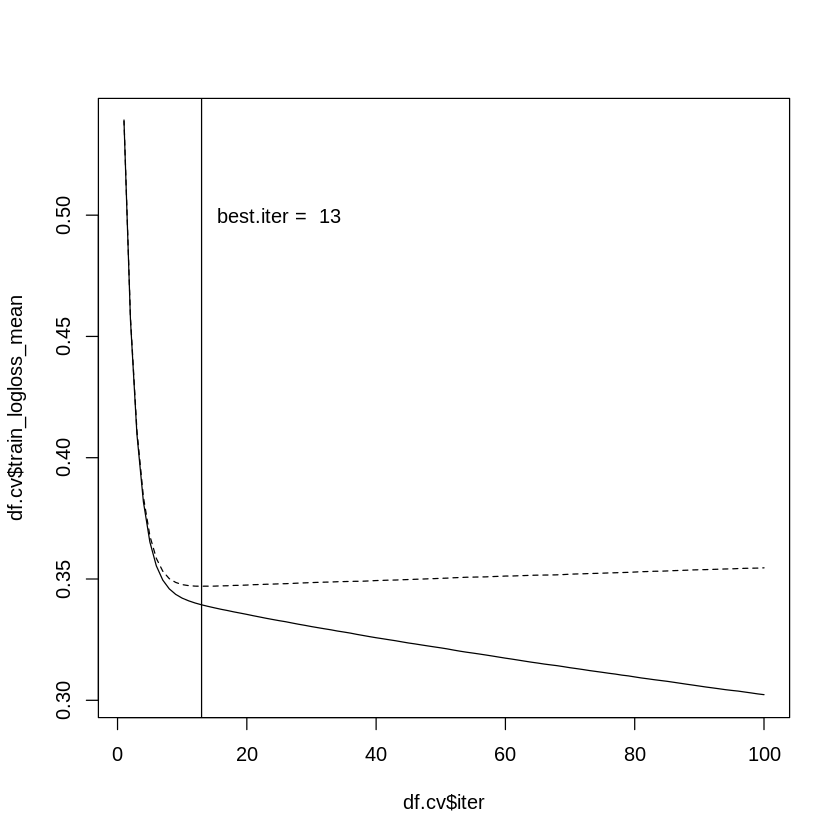

In [ ]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(25, 0.5, paste("best.iter = ", best.iter))

In [ ]:
m.xgb2 <- xgboost(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 14,
  verbose = 0)
df.train$y.pred.xgb2 <- predict(m.xgb2, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb2 <- predict(m.xgb2, newdata=as.matrix(x.test), type="response")

In [ ]:
statline.xgb2 <- build_statline(y.train, df.train$y.pred.xgb2, y.test, df.test$y.pred.xgb2, "XGB2")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2)
statline.all

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5957808,0.1915615,0.5966333,0.1932665
XGB,0.7747078,0.5494156,0.5787829,0.1575658
XGB2,0.6450874,0.2901748,0.5982444,0.1964888


In [ ]:
xgb.importance(colnames(x.train), model = m.xgb2)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
x.Age,0.355537997,0.291192100,0.138761468
x.Tenure,0.097194057,0.175859987,0.094036697
x.V1,0.080319562,0.087680136,0.118119266
x.Gender.M,0.061044722,0.019084509,0.021788991
x.V2,0.059189840,0.075761768,0.086009174
x.Territory.U,0.056931390,0.114963113,0.045871560
x.V3,0.052462447,0.050727151,0.086009174
x.V6,0.045779611,0.030837238,0.079128440
x.V4,0.038152950,0.021633403,0.072247706


At this point, we're already better than the naive (and rather misspecified) GLM. We still see separation. Can we do better? Let's look at learning rate.

In [ ]:
params = list(eta=0.1,
  max_depth=6,
  subsample=1,
  colsample_bytree=1)
start.time <- Sys.time()
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 100,
  nfold = 5,
  early_stop_round = 10,
  verbose = 0)
end.time <- Sys.time()
end.time - start.time

Time difference of 1.387686 mins

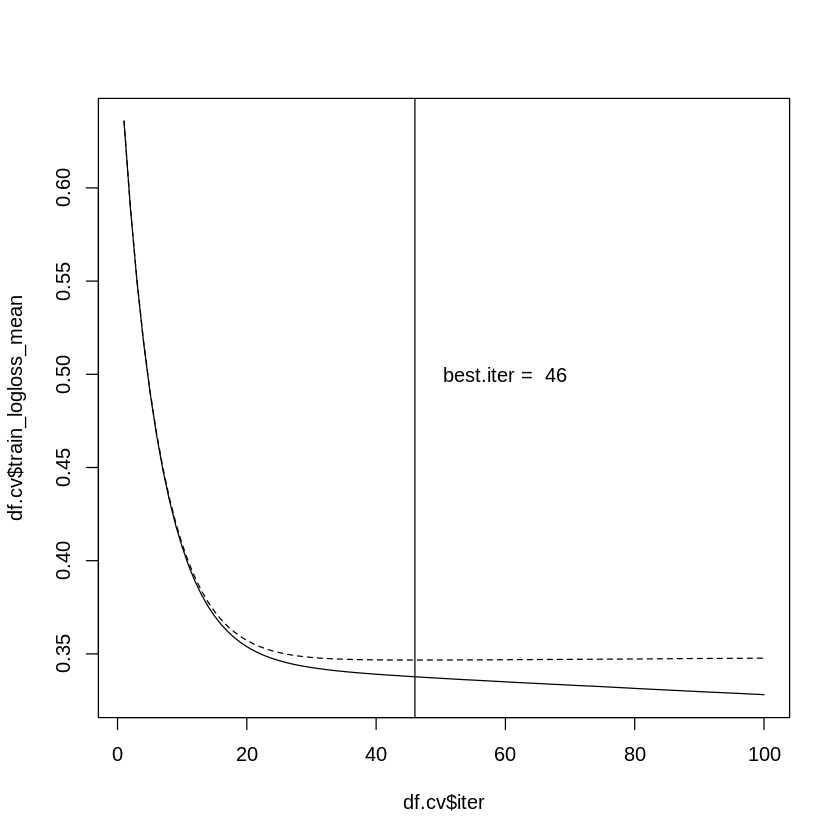

In [ ]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(60, 0.5, paste("best.iter = ", best.iter))

In [ ]:
m.xgb3 <- xgboost(data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  eta = 0.1,
  nrounds = 46,
  verbose = 0)
df.train$y.pred.xgb3 <- predict(m.xgb3, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb3 <- predict(m.xgb3, newdata=as.matrix(x.test), type="response")

In [ ]:
statline.xgb3 <- build_statline(y.train, df.train$y.pred.xgb3, y.test, df.test$y.pred.xgb3, "XGB3")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2, statline.xgb3)
statline.all

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5957808,0.1915615,0.5966333,0.1932665
XGB,0.7747078,0.5494156,0.5787829,0.1575658
XGB2,0.6450874,0.2901748,0.5982444,0.1964888
XGB3,0.6500913,0.3001826,0.6002182,0.2004363


Got another step here. We'll make a final step, and sample on variables and features. This will generally help mitigate overfitting as well as increase the chance for variables to shine if they are meaningful relative to the response.

In [ ]:
params = list(eta=0.1,
  max_depth=6,
  subsample=0.6,
  colsample_bytree=0.6)
start.time <- Sys.time()
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 200,
  nfold = 5,
  early_stop_round = 10,
  verbose = 0)
end.time <- Sys.time()
end.time - start.time

Time difference of 2.197741 mins

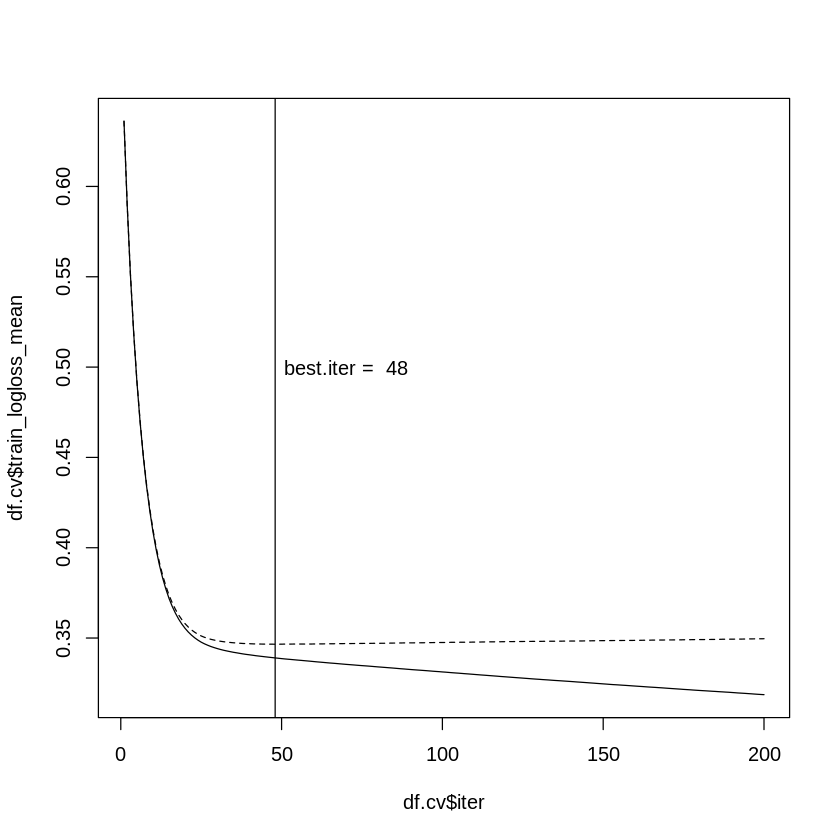

In [ ]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(70, 0.5, paste("best.iter = ", best.iter))

In [ ]:
m.xgb4 <- xgboost(data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  eta = 0.1,
  subsample=0.6,
  colsample_bytree=0.6,
  nrounds = 48,
  verbose = 0)
df.train$y.pred.xgb4 <- predict(m.xgb4, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb4 <- predict(m.xgb4, newdata=as.matrix(x.test), type="response")

In [ ]:
statline.xgb4 <- build_statline(y.train, df.train$y.pred.xgb4, y.test, df.test$y.pred.xgb4, "XGB4")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2, statline.xgb3, statline.xgb4)
statline.all

model.name,model.train.auc,model.train.gini,model.test.auc,model.test.gini
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM,0.5957808,0.1915615,0.5966333,0.1932665
XGB,0.7747078,0.5494156,0.5787829,0.1575658
XGB2,0.6450874,0.2901748,0.5982444,0.1964888
XGB3,0.6500913,0.3001826,0.6002182,0.2004363
XGB4,0.6465869,0.2931739,0.6020298,0.2040595


In [ ]:
xgb.importance(colnames(x.train), model = m.xgb4)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
x.Age,0.258565703,0.221448608,0.107032590
x.Tenure,0.097882615,0.119865843,0.069296741
x.V3,0.086874633,0.090318213,0.131732419
x.V1,0.065674296,0.093612359,0.078216123
x.V9,0.060308863,0.041869156,0.091595197
x.V6,0.055701300,0.044138658,0.092281304
x.V2,0.054356445,0.076354210,0.070668954
x.V8,0.049868636,0.029678923,0.082332762
x.Gender.M,0.046497797,0.023146095,0.018867925


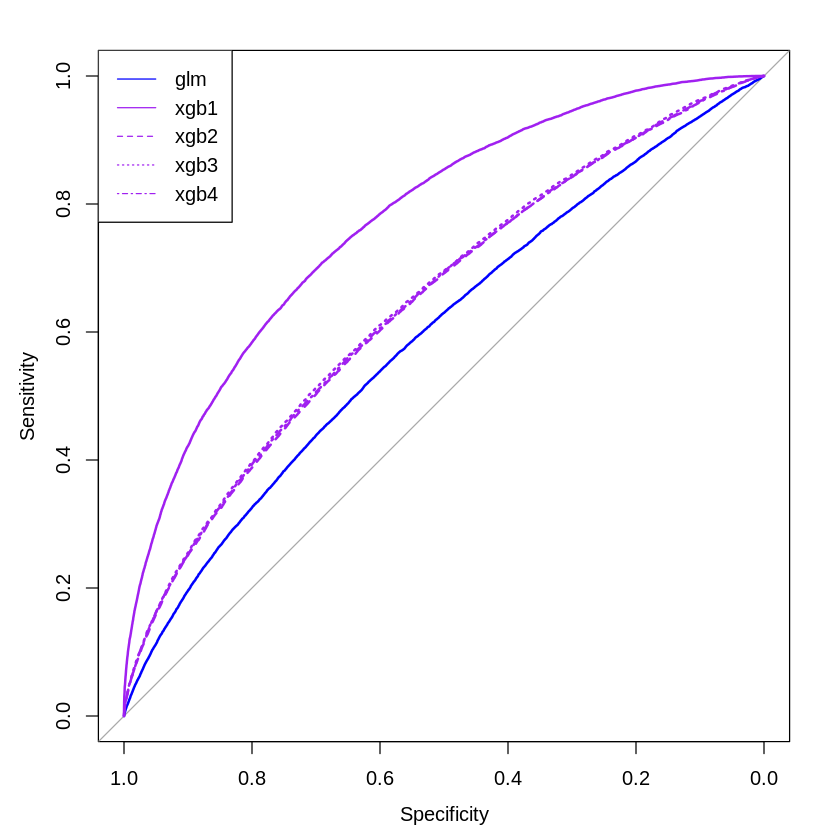

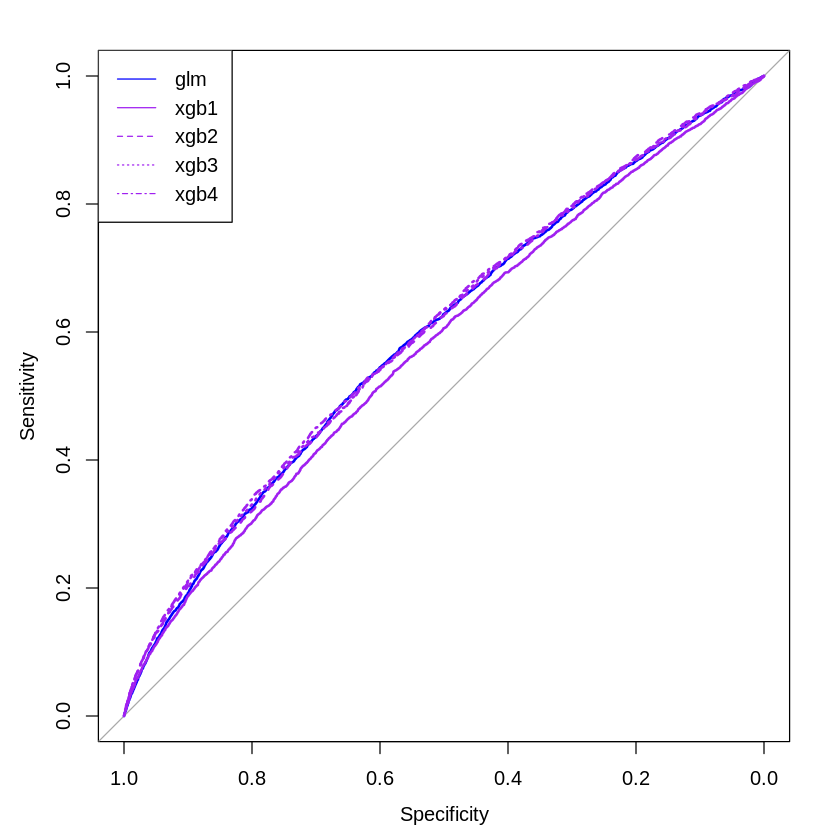

In [ ]:
quiet.setting = TRUE
roc.score.glm <- roc(y.train, df.train$y.pred.glm, quiet = quiet.setting)
roc.score.xgb <- roc(y.train, df.train$y.pred.xgb, quiet = quiet.setting)
roc.score.xgb2 <- roc(y.train, df.train$y.pred.xgb2, quiet = quiet.setting)
roc.score.xgb3 <- roc(y.train, df.train$y.pred.xgb3, quiet = quiet.setting)
roc.score.xgb4 <- roc(y.train, df.train$y.pred.xgb4, quiet = quiet.setting)
plot(roc.score.glm, col = "blue", add = FALSE)
plot(roc.score.xgb, col = "purple", lty = 1, add = TRUE)
plot(roc.score.xgb2, col = "purple", lty = 2, add = TRUE)
plot(roc.score.xgb3, col = "purple", lty = 3, add = TRUE)
plot(roc.score.xgb4, col = "purple", lty = 4, add = TRUE)
legend("topleft",
       legend=c("glm", "xgb1", "xgb2", "xgb3", "xgb4"),
       lty=c(1,1:4),
       col=c("blue", "purple", "purple", "purple", "purple"))

roc.score.glm <- roc(y.test, df.test$y.pred.glm, quiet = quiet.setting)
roc.score.xgb <- roc(y.test, df.test$y.pred.xgb, quiet = quiet.setting)
roc.score.xgb2 <- roc(y.test, df.test$y.pred.xgb2, quiet = quiet.setting)
roc.score.xgb3 <- roc(y.test, df.test$y.pred.xgb3, quiet = quiet.setting)
roc.score.xgb4 <- roc(y.test, df.test$y.pred.xgb4, quiet = quiet.setting)
plot(roc.score.glm, col = "blue", add = FALSE)
plot(roc.score.xgb, col = "purple", lty = 1, add = TRUE)
plot(roc.score.xgb2, col = "purple", lty = 2, add = TRUE)
plot(roc.score.xgb3, col = "purple", lty = 3, add = TRUE)
plot(roc.score.xgb4, col = "purple", lty = 4, add = TRUE)
legend("topleft",
       legend=c("glm", "xgb1", "xgb2", "xgb3", "xgb4"),
       lty=c(1,1:4),
       col=c("blue", "purple", "purple", "purple", "purple"))

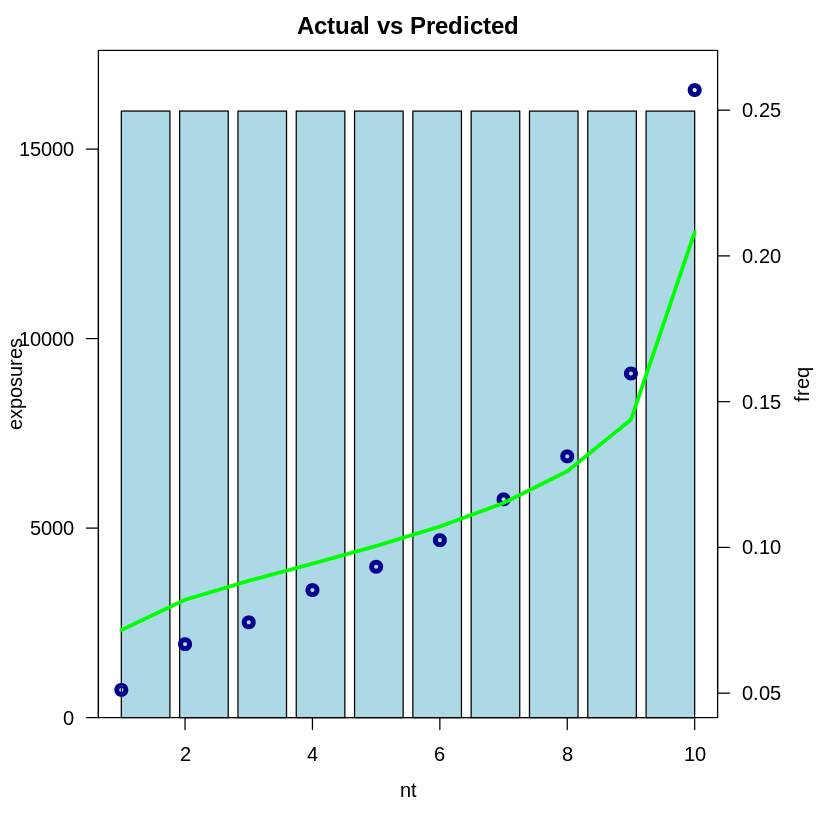

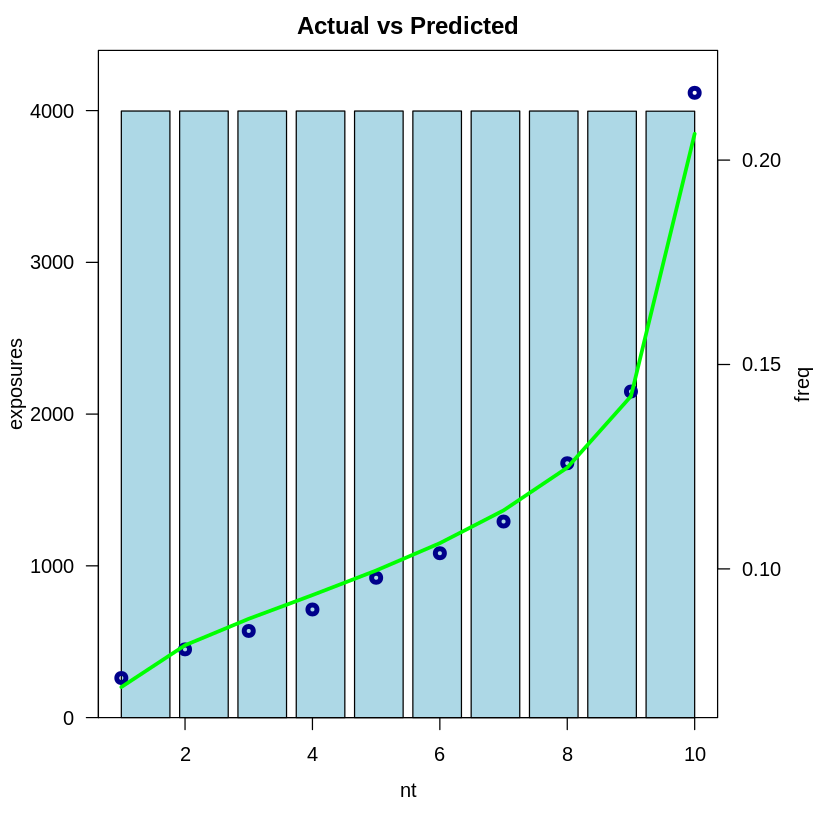

In [ ]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.xgb4, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.xgb4, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

In [ ]:
colnames(df.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"  
[19] "y.truth"               "y.out"                 "exposures"            
[22] "y.pred.xgb"            "nt"                    "y.pred.glm"           
[25] "y.pred.xgb2"           "y.pred.xgb3"           "y.pred.xgb4"

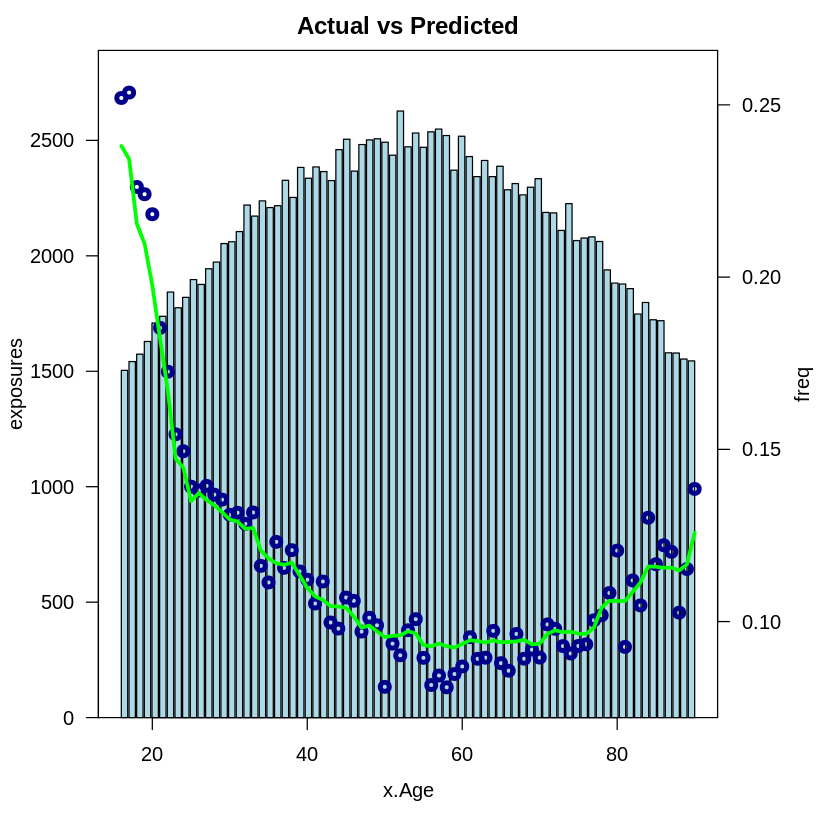

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

Next, let's go to a third example, this time another step closer to real world data. See you in the next notebook!

# End